In [1]:
import numpy as np
import MSMRD as mrd
import MSMRD.integrators as integrators
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#define MSMmodel class to read in data
class MSMmodel(object):    
    def __init__(self, tmatrix, centers, parameters):
        self.tmatrix = tmatrix
        self.centers= centers
        self.parameters = parameters

In [3]:
def discreteHistogram(data):
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    hist = plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
    centers = (hist[1][1:] + hist[1][:-1])/2
    return hist, centers

In [4]:
model = pickle.load(open('../data/models/asym2D/10radial48angular10lag.p'))

In [5]:
print model.parameters

{'NangularPartitions': 48, 'outerBathRadius': 4.0, 'bathRadius': 3.0, 'exitRings': 4, 'NCenters': 9, 'entryRadius': 2.6, 'entryRings': 6, 'interactionRadius': 2.0, 'lagtime': 10}


In [6]:
T = np.copy(model.tmatrix)
for i in range(model.parameters['NCenters']):
    for j in range(model.parameters['NangularPartitions']):
        T[i,-j-1] = 0
for i in range(len(T)):
    T[i,:] /= np.sum(T[i,:])
#print np.sum(T[:,-15:],axis=1)

In [7]:
MSMlag = 1
msm = mrd.MSM(T, model.centers, lagtime=MSMlag)

In [8]:
#overwrite exit states, now there is only 1 state from which the MSM can be exited
msm.exitStates = np.arange(model.parameters['NCenters'] + (model.parameters['entryRings']+model.parameters['exitRings'])*model.parameters['NangularPartitions'], model.parameters['NCenters'] + (model.parameters['entryRings']+model.parameters['exitRings']+1)*model.parameters['NangularPartitions'])

In [9]:
#print just for checking
print msm.exitStates
print msm.entryStates

[489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506
 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524
 525 526 527 528 529 530 531 532 533 534 535 536]
[0]


In [10]:
p = mrd.particle(np.array([-1.9, -1.9]), 1.)
integrator = integrators.MSMRDexitSampling(msm, 4.0, p, 0.1, model.parameters)

In [13]:
sim = mrd.simulation(integrator)
sim.run(10000000, sample=True)

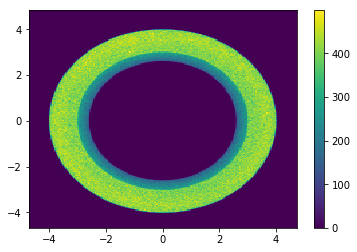

In [14]:
BDregion = np.where(sim.traj[:,3]==-1)[0]
obj = plt.hist2d(sim.traj[BDregion,1], sim.traj[BDregion,2], bins=200)
plt.colorbar()

In [15]:
class asym2DmilestoningMSMRD(object):
    def __init__(self, bathRadius, Ncenters):
        self.bathRadius = bathRadius
        self.Ncenters = Ncenters
        self.Nstates = Ncenters+1
    
    def getState(self, sample, pdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAWUAAAD8CAYAAACvm7WEAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzsvXeUXfd13/v5nXLP7Xd6A2Yw6CB6IcEqNjWTpinJRZZt2amWHTuOUxRbSmLnvZU4cV7WSxx7vfViRYltOXLhsy3JlEVREiVSBCt6BwYzwHRMn7m9nPJ7f/zO/AaECBYTEgHifNfCwr1zzj3nd9o++/fd3723kFISIUKECBFuDBjv9gAiRIgQIcIKIqMcIUKECDcQIqMcIUKECDcQIqMcIUKECDcQIqMcIUKECDcQIqMcIUKECDcQIqMcIUKECDcQIqMcIUKECDcQIqMcIUKECDcQrHdjpzHhyDipd2PXESJEuMlQZHFOStn+Trbx4YdScn7Bf9P1Dp+oPy2l/KF3sq93infFKMdJcad4/7ux6wgRItxk+Jb8i5F3uo35BZ9Xn+570/XM7gtt73Rf7xTvilGOECFChB8kJBAQvNvDeEuIjHKECBHe85BIXPnm9MWNgMgoR4gQ4ZZA5ClHiBAhwg0CicS/ScoUR0Y5QoQItwQCIqMcIUKECDcEJOBHRjlChAgRbhxEnnKECBEi3CCQgBtxyhEiRIhwY0AiI/oiQoQIEW4YSPBvDpscGeUIESK896Ey+m4OREY5QoQItwAEPuLdHsRbQmSUI9yYEAJuksBMhBsfKtAXGeUINyPEFTeulCvff9AGMjLIEa4jlE75FjPKQggTOARMSCkfu17bjfB9xBt5o8t/fzPj+FaN9vJ6IuyrIIPXGv2r92uYELyNAjJXH0vkaUe4CsEt6Cn/KnAWyF7HbUb4fuNq4/VODNuV6wuhDPCyYV02wFcb2qu3b5jq/8D/3u1dbcRfb2xXG/lrGf2rx/t63yO8Z3AzecrXpR2UEGI18MPA56/H9iJEiBDhekIi8DHe9N+NgOvlKf8O8GtA5lorCCE+BXwKIE7yOu02wjvCm3mFVy9/PU/ySk/2iv+t1avw23KU16YB8OKCWrNBvWX5d+AlpXYL3GYPa8lChI60syjwY+jlycsSswGZsToAsckCcmySoFJ5/bG+FfrlWr+J8J7ELUNfCCEeA2aklIeFEA9eaz0p5eeAzwFkRUt09/8g8XZ43yvXuZrXlRKzKQdAsKGXuT0ZimvUosaqBndsHKYrXgAga40QN1wWXfUCTpgu2xPj1KQNwNfmdvBo20mKfgKAv5neTlu8zJb0FAAddoF6YFMJYgC0WUUu1dvJmDUAHMPlYrWdi6VuAM6Od8GMQ/aisuKJuYCmI7P4Fy6+9hhf70XzVs5NhJsaEkFDmu/2MN4SroenfC/wuBDiUSAOZIUQ/1tK+cnrsO0I1wNX87LLeCMO1TAxdmxi6t5mAAobA9o3z/GJNYcAqAeTHFxaw0Ot5wHYHR/hqcIu7k+fA2DMbQWg214CYKjWwayXpSbVLbc2NU/GqHGyvBqAn131Mg8nRni+tgqAmPBZ8pNcqHYAMFjpwBABsyjPe3tqkla7jJFR4+/fvIC7yeCRHzkJwDeWttMZK3B0qReA8zMdcCpDxxEPgNSLg/gLi2983t6OwY746BsaKnnkxqAn3gzv2ChLKT8LfBYg9JQ/HRnkdxGvZxyuZVzC72a7ahScf2g9kx9QnvEP7znB7Zln6LfnADhYXcucm2F3fBSAgUYXn+p+jklPGe3/NXM/fYkF7Qm3WwWeK2zhnswgALbhM1Rrp8MuAtBilTlf6+bh3BkAxhqt/M78fax1ZgGoSZsWs8TGxAwAc16aZqtM3kuGvy+xJjZLMVCeti08lvwUr5bWAbAzNcaCl6YnmQdg16ZxFtcmSXzUBeD9mdP8o5c+Seqo+n3rGRfnmeNIz105N1opcg0VyJXnNTLINzxulkBfpFN+r+FaBnn5s5RY6/oBGH+8h9LtVT6wSXm326xXcAzlSfY587RbBQYaXQC0W0X2JoYZdRUp7EqTuOGSMRSd0OaUKPmO9kbazQK/3vE8TmjYprwcHXaBQKrvhgioBzatRhmArkSBLjtPOXAAOLzUT3usqOmLn299npP1HibqzXr/g/Uu2ixFl/jSpstaoimltlcJHFxpclf4Uuiwiiz5SXrteQAOlDfzo9uO0b9PvXQCaXCh2sFXX94PwNq/8rCfV163vFoJcsW5vOb3CDcUpBT48hbxlK+ElPJZ4Nnruc0IbwHX8oRDQ7HsCc98dAPy8Xl+acN3ARhttNJslbWhXOfMkBQqkHa81sdQbQt9jjJi5ytd1BK25nQDaXCgtJldSdX9fWdyjPFGC02GCrwtBUmeLPWwxZkEIO8l6bTztNvKiNakTZeV50Rd0QutZomRRht2GOnblp7ARNIZ0h/zQYIlP6mXb4ldZli08XJpPQAPZs8RYLAlNg3Al/J7abOLzHlKodlnL1AOHC6EL5mk0WBbckJvb6TexqNNJ0jfq45//ftnMIWqlvBbX/4xVj3n4Xz90Mp5vtogC+O1HnVkpG84BJGnHOH7gtfLuLuGd+w/uIehnzH4pbu+A8AzMzF+qfc7ZEPvttee54XyJnYmxgDoMvM8X9kEgInk/ZnTxEKjFUiDdqtI3GgAsMpaZGusyJOhUbwjMcwqa5HTdcUJV4IYD6fO6inj6tg8rVaJV8tq/T3JES7Uu6gHiu44Wl/Dh7In+U5xKwB3py5wtNpPXCg64ZniNu5NDRA31Pcht4MTlV4ezir6o8mscK7eo18K2xPj9NtzHKyuBeCpwk7a7CLrYooeabcKDDfaWWUrXnmk1kLJd9iSUC+Rr87t4sOtpwH46Ue+y+z7M1z4tOK/p57upe8LQ3hT0yvXQfrXpjMiA/2uQwX6bg5zd3OM8lbG20juMFIp5n5yJ62fVLzvp/u+yJKfZNJVU/7f6H+SJqPOcMgDF/0ED6XPah74XKObvYlhAPqtPF8rbWOoprzsezIXiBsNLtY7AeiNzTPm1ZjzlApyjSX54uJO1scVB/zjmeMcqfeQMpTn2WqVuFjvxA1UBPxCvRMTyUS9CYAHsuc4U1vFnqTa/6uV9fxY9ggX3DYAHsmc4LnyFvaE4ztf72F9fIZvF5QRvyN9CVea2ELRL4P1Tqa8nJ4F7EtdIi5czUGfrfTwWOY4h2tKPrImvsDWxAQFPw7AL3Q/q18QS26S0XIz6zKK6njokwOc+Wg3Lx69E4ANX6whXjx+7Wv2en+LDPUPFLdUoC/CdcQb6YCvXi9cZnV1cukfKu+z96FRPtb+bTbHLwOw5Cc5WlnD/pSShR2sruPB5HnN256t9eDHDVZZyltstwp6On+y0cUDqfP0hJ7kvJ/mbHWVpi8a0uSvC3u0lz3pSTbFpzhT6QEga1Tpt+cwQgpgzG3FR3B/Rqk1yoGDLTyc0PMdrHdxT/KCPsS8l+Cp0nZypvJ8T1V7uTM1yMmaojtazBKmkNyVHlL7d5tZ58xo1ccGZ5pZL8N6Z0afiym/iVazBMBD6TNM+Dn9UtkQn+J4pY/bEhOAmiksBx2njRytsRJtlvpt3k/woZZTNO2vqt8+OM3vHn6Yvj9TLxznawdfKydcntFEgcF3Ff6tolOO8IOH2aa8x+Ff3Mgnf+IZ7kbxus1WmfWxGQ6UFAXxSPY4S06SYqC8v7hwOVxbQ3sYHLs/fe413mO/tYgRdmeY9bK0GJ72dHc4lxmLZTlUUeqGWmCTM6s6cLYQxLkjMayzogwRMOR2UAvpiTkvw+b4ZU1nTHk5tjiTWk0x42bYlYjxTGFbeCwVXGnSFBplW3gUg4T+vuCn2ZsY1tvfEpuiJi2GAiWhawQmO+JjpEL641y9m4rv0BeO92B1HbbwWR1bAJQE7/bURczw+BvS1Odtb3IYH8GSnwLgciOHKy3+UfuzALxcXcs/3P0C9V3qcXri7+2l4wsJ4k++qi5Y5CW/61jO6LsZEBnlGwFvFKi74u9GMsn0z+3ig7/wEgA7mMU2PG1IKkGMKS/HI1k1lX6udBvbE2PMhsGujc4U835aB7CmvCZcabLDGQegJk0mPEUnbIlNc6DaqyVxL1fXkDIa2pNutUr02Qv8z9n7Abg3e4E5L8udSaV2OFZbw+VGE59qUWP9g8X9tJglXipvBODO5BCFIM5P5Q4D8JXSdpb8FPvTyqtf8pOsi80w3FAvoNFGGxucab3/JrNCMYhTC9UZU16OLiuPGyYI9NrzDLvt2jtqMiu0mCU2h0a5Jm1+OJnnpboZnjuHmrSJG8r7PVNbrfnsmrSZ99L0h3x0Jl3FlRYn62pWkPeTrI7NM1BTiSx/dPv/4qlNu/j6L92m1v/3mdfSG5FBflcQ3IrqiwgRIkS4EaEKEkVGOcJbxbUqoYWfKx9TAaXUr4zzn9d8jh5TJWA8Xd7KHYmLdIVT+q+VtlH0E8TDYNeu5AgmkjvC4Ni3Slt5OHWWKV95zrbw+GBylClfeYtn6t10WSrZYspPa+4ZwJUWcaOkOeaxRivtVpGdaeVljzba+HjusPZMW80SDzYN8OeFXQAkzTpHqv00W0pHfK7eTZNZ4aslRVf02IscrazhY6Hn3GRUNFUCsDq2QNKoc7Gh6ImMUWPKbeLF/AZApXFnrSr7UupY+6085+o9ZELP91K9nbtTgzxd3gwoz/hzbrP2nnJmmZqMccFXgcwd8XG2xpRX/c3yBuKGq/nqXnueKS9Bl6Xkek1mhSU/SXdMfX+xspHpRpYfWXVKneff9/jvR+9n039SYwlOn3/tdX+niOiQN4VE6FnUjY7IKP8g8UbZdq+zjrh9Oxf/hcmHNhwDoDVWwhY+T5W2A0pmNua2MhVSDnk/wW3xSW10QQXE4uGUf4Mzxau1teTDehMfTp9m3heMhb9fpgZABbrWx2Z4qrgTgNvikxT9BBlTGRYfgyU/qY2ea5r8j/n7dODtVFXJxzpDI+9Ki/7YrKZSlvwkDWlqjnm80UrSaDDkKrXHpNvMcK2VrclJfRzLvwVlVEfrLaxOqJfEWmeWyUazXj7kNrM7PsK5kGL4UOYkE14z7VYx3L+PLTyGQjVJj73IvtgYx+pq3DNeBiPs6rbgp9gbG+Yri3sByGRrZIwq7aZ6wTxf2ciil9L89LFyH/vSw5qTtoXPr+z9Dqf/p5ILHvibu+n/rycJikWuCyKD/KaQklszeSTCm+D1Hp6r/mZ2djDwaaWm+Pkf+hZ3BjH6Qo+ty17ClSYLXkqv/1jmJH+4cDcAH206zJjbis0K79pu1DkSGqYpL8eO+BjHq0oGtuAnqUmb4YYyhP2xWdaEQUBbwEUvzaa4KhDkYzDeaNFqiql6jl2pUS6Hcrs7k0NUfIejFbXthzJnGGp06oy89yUH+LPFO9mRHAv3NceRSj/3pZXXeKC0mQChPdfLjSYeazrGbPiCudjoIJCG3v9mZ5KkUeeyq14ovjS4VG1jjaM48KOlNXTHljQvfKy2hkAauvZGyY+zMzHGbXFl9ItBnCG3lWlXFVy6PXmRSjhT2BqfYN5P82jTCQDazSITXhMXQ7necwubeLjlHCN19f3h7BkG6108kDoX7ruPVfYil2NqrPt+6Awtj9c48Zt3AKFa483qREd4hxBR8kiEt4Hwgax+5A42fuYMD6S+BajAnSM8NjrKMJ6r9xATni76A3Cy3s3juaMATHrNLPlJlnylaNhoL3LRy2kFRVy4BNLgsbRKivivsw/xky2vcFdCebdjXgtfK6vgVK89T03aesq37EX3hBl27VaRlNHQ3uFThZ3cnR7UnvOhyjpqgU3BU97isN3GXekhRsLAXd5PsTUxoTXUtuGx0ZnmYr1D7+/Vynr6YsrIni13szk5TSnUES/4aUYbrdr7Gah10R4raslb0mgw52a0xO1yrek1M4G+2DytZokZX0ni4rgs+GktyztW62NdTMnp2s0yp70eve0xr4UuM898oF6On+x8iSU/qR/6mrTJmRW+FVIzC16K/amLmt54PHeEP52/m65/rc77q5/Yy5Z/MYY/N/e690VkpN85JJGnHAHeEtdnZrNc+Nfq4X3k/Yd4tOkEhXDaW/QT1KStFQvd9iI1GdOysDG3lZRR1xxyk1HBNw0uhp7vV0rbCaTB6tDT7o/NkjTqfLuieNifbnmZl6vrtdGfcnPas1zw02SMGrOhjnei3swqZ1Eb+LFGK0mjro32WmeWLjOvjdxjmRN8u7yFtrAA0cul9TRbFXKWGvsqe5Fy4Gje2kRqL3sZRT+OKdT525MeZbTeqtO+5/00bVaJzWEa97PF29iWnOCVMGNwsp6jx8kzHXrSa51Z4sLluYLilJNGgxk/w4tFdW4dw2N1bJEhV70UXGnpYkvHa33YwudctSdcZrIjOabHljLq5P2UnlXEhUtN2OS9hD6WHc5l/cI6WF3H3dlB7Vlv3jVN7Rs2L/+GqrsR/+qrb78dVoQ3RRToi3Btgxx6QGLfNhb/XZV/2f8VAOqBzXCjjQVPlafcmxymEMQZrasA0/bEGMcra5i1leFzpUmPlWcqNJzHa3302Evam+23Z5n309obLfoJ5rwMa5cTKoIkA5UuLanrsRe1N/hKZT0t8ZI2+HekL+FLodOYfdvAFAEj4b7dwOJYrY8LVcXRDjpLtFglXS8ZlBb54bRKiz5c66fLyvNSSb0gPtB0mrFGK8XQE0aohI6zVcXDZswa25ITDNRWalfUApu/LN8OwIbkDJfq7Zou2ZCcYazW8popa6e9RNlTL4He2DxHK2tIhmnjD2bO8kxxm/79mtic1mBPuzk2xid0ENQWPqYI9AtsIjy/y5ppk4CBWjfNdlmvf7DWp19o9yQvcKHRRUuYjHKh2knJd7jr3yld81/vvefNOecouPe2IBG3TpH7CG8Thsn0Lys1xS/+o69Qk7Y2hEsk6Y/Ncg7lka2zFzhZ72ZnyMOCMlTna+FyZ4YpL8OUp3jQH80c53B9FdtiymN7In87m+JTHC72q98mZ7CFz2Bo2NY4cySMBqNhO5BKEMOMB/pz1qjpRJMuK89Qo4NvFFSQsc0u4UqTdJjhN+PH6bLzOmU77yXJmRXtSXfECiy6Kf46vweAnFXlO+Ue7ssOACrtWhUtUvtzDJdXiuvpiCnDdGdykC/M3cvfazsAwO/PPMiO9ASt9gpH7EsDMwzOtVtF2tNFHfwbbzRT9ONsSyvPuhw4dNtLXKqrWcX5eg/bEuM6kaYQJHgqVI7sTw1hIjkf6pBzYWLLchDTR3HVcw31Ml3rzPIzTa9wJix+VA5izHoZUjFllCe9Zl4qbOCTrS+G59phuNbKRFV59R98/CCH7+kl+xmVvRgcO/M9t1GUjPL2IFGzn5sBN8co3yMw4nHO/bcd/MydzwOo6b9vaU+2NzbPkWq/Loe54MepSZumMMp/sd6JK022xhVPOuNlKBDnSLkfUA93JXC0x/b+jOKOOx1l6B5Kn+Fbxe06eeREpZdmu8KmMC27yajoZeudaQYaXToD7k/n72RdYo7uWF6P9VR1tTbaTWaFuHAZqykDn7VUXYxlHrfiO9iGz0PpswD8TX4X6xKzuspbdyzPkptkNjRs+zIjpK269pxP1nrpcgocrCqZ3I70BBer7TpNe3dqhEm3mcGK8tS7rDyFIE6nvaz+MDFFoNUeceGSsav6QZ3z0tSkpc993k/QEsr3atJm1svqbS0HAJeLNe2LDzHhZV+TbXim0aXPzfnSZvYmh3UizEZnittSkxyu9et7oz8+T2voWa9x5pirp6n9rhrb4m/dTuzpQ1wTb6Vt1y0PEdVTvqVxlczN3KgMyfB/SPDvd/wVkyHPuc2Z5EKjk7Oh55s06vxk9jgXXaU4KARx7oqPcDCs9/BA6jwvV9fpQF5M+Iy5LfxK27MAPFnaji18LfOa9nL02Es6GLfgpzWnC4RpxvOcDuVrObOqdciHSmsxhKTkKKP4SPNJptyc9ixr0qLoxzlcVlXY1jqzTLpNuupbxlxisNrBvvQwoAqMZ4waTxWUxC5pNuixF7WnPdFo5rbUpDZsrWaJQApdm6LJrDDnZbTnPe1mMUTAo00qU+6l8kYOLa5hdVJRN98tbsbHYK6ujPzuzBiXGznabDUrOVzuZ3/6on5Q5xtpXMvkZNj5ZHdmXBv8VdYiB91m+sOg45nqKlqskvacl/wku+OjLPhqX8NhCdJlHfM9qQucrq/SY99q5+kxixwPK+r5pkGrWeJCXXnWk41m7m8eWJHv/c5J/q+//Bj9v/GyunBv1tU7MsjfA0mU0XdrY7ljReAj79kFv6XSc3+t+3mazLI2bN8qbcOXBvtTKgo/76X5i8JObQzOlnvYnJzSgbhZP8VOZ4yyVLznH0y/j13ZMZ4MdcvKG/S0hA6UKmG5sM5Qo4N98WFtiL5R3MEapOZVk0ZdKw5amkoEGJqOGGu0YguPfalLgOKn816SBVcpEM4F3TiGR5ejvMk1sTlyYSo0KE95pNrG3VmVhr3KWuRkrZdcOAtotsqYrPC0M16G8UYLHwi9/T+evYeWWJmKUMfeHVui3Spq7fJUPcfW7GWGK4p/vz93jleK69mUUuU1z1a6WROf15K6emDhS0OrOfZnhni1uJ4dGTULcQxX88sna7240tSBOjtsBLA9oRJnxtwW5oOULkt6b2qAry7t1tdgvNHCx3OHmA3Uy3TSj3Gu0U2/ra7LlNdEQ5paP+4YLu9LDvKHC/eoc+Us8ps/8QT/ZtVHAbjtVy/gFwpEeHu4np6yEMIEDgETUsrHhBAtwJ8D/cAw8HEp5WK47meBfwD4wD+RUj79RtuOjPIb4W87DQyj5oWfuos7P32IO9LKkC3zncva2PclLvP/Ltyhy2FebuS4NzPAlrDexLIsTRfxcVvptee1YuHxtqMseGntTa51ZikHjq4R/Ep5PatiizpgdaHexeFa//d4DL/eqmRg/3lhvfbCj9f6SBoNLjeUVz9dz/K+3HkuhZK1pNFgsNzO+5rVb89XuuiOLWkjd77WzfbEGE9PK2XJTCVDX2aBJ+cUTztSaCZfTtDdpIxLwnKZrya1osEy1Lk6OK8UGZlYjdWJRUphoG5dbIYFP813C6r40ubkNJUgxr3Nyug/tbCTvZlRnl9UgcSd2QlmGhl2pVRZ0/Z0kZFGm6Z6XihsZE96VOueW8wyFZRR9jEYrHTorifdsTyutDhR7dXn/dv5rfxos6IYvlPaSm98Qdd+fiR7nN+fv5+0qTjlPmeekh/X1yVl1Bl1W2kLPeNL9Xa+Ulgx6hXf4USjiX+w7wUA/vh/7GfDpxfwxidecx0jD/nakFJcb0/5V4GzwHJG02eAZ6SUvy2E+Ez4/deFEFuBTwDbgB7gW0KITVJeq8cYN4lGJEKECBHeAVSgz3zTf28FQojVwA8Dn7/izx8B/ij8/EfAR6/4+59JKetSykvAILD/jbYfecpvhLfreYSe9ewvqgy7D/7CS7TZRe19lvw4P5c7yrfDjLo/L2xle2JcUwQ5s0y7WeRYmIE3WO/keGE1+5uUp91lKS7yS+VQRpY5xYHCJu7MqMpqpyuruD9znqGwPgSoLtLL0/A5N0PVt3VAaVN8isF6J18Il/fYS5wK+Wtb+K9JHS75DpfdZh3sKgcOP9F+SHuLp5e6maunOTev9l0qx/G9ewjclRt9RLRCKEsSZRMyHhcL4VgDwBcIV/kJ9qKBt7aGzKuxSSE5bKyDmPKgn0zsCM+5ukZjnc30pxeo+Gr9/sQ8NWnxWJvinEcbbfgYmm8frzazIzOu6Zf2WImMWWO8ofYfN1wCT31uMiv0OHkd+PtI5jRfKW7TNFFDWuxNj3AsLJjfZhXZ6EzpZIUj1X5WOYtaXjjjZlkdW9ABw0IQZ5szrqWJrxTWsa/lkv7+cmk992YuaA77E1sO8/IfrsX8RcXn+4OXIi/5TfGWe/S1CSGujKp+Tkr5uavW+R3g14DMFX/rlFJeDj9PAZ3h51XAy1esNx7+7ZqIjPL1hDC4/M/v5PGfVeqK1bEFLlQ72ZhQvOZt8QkO1jvY4ahp5xHZx5SXY1v4fcbPcLLWq6P2bVaRn+t8kZdCI9xl5Xml1s/esDvHXy7dQUdsxeh3x/IcKG3Sioe44RIg9MNtioCE6bIhTHIA2JMY5nz4EvARKzpfZ5qzXorxhlJT3JO5wBPTd2it50i+mYXpLISGy8qbzG5eojSmZnPSkhg1A2GvGAtpqL8BBIkAkbcJWQoMV+A1e4QMD40OD2syjpdVxyI8gVE28FvUCu6ig9XUQIRG+dypXs6mevTvhSXZ2j+JES7fnlWU0TL9sS09yUCli1jID7vS5Gy1h8s1JS/cnhjnXFkF3vJegv74HEM19QL50/weRmqt+rej5WZ25CbJhXVBRustXKq3syfsX5j3kxgi0Nd1R3yMJqPKhK/2FUiDNVaF58KXdX9int3OJFNh/eY70hcp+HF9bWqBzWNdJ3nm81vU909vRx48SYRrQwX63hKnPCelvP1aC4UQjwEzUsrDQogHX3dfUkqxfGP+LRAZ5TfD6xUovxJSquwrYPCPdvIbd/yFzoIrBnESpsvuuOIxj9X6uFRvZ8xZ4RLXx2Z0Bh+oym2HK8oDWu9MUw4cnSk276epBDFaQl0zwEi1lTOe8qBSVgPH8NicVOtvjY/rymagjEVHrKCDY6P1VvYkR3QLpRPFflbHFR8962Wp+DFenFFjeWJpD0FgEMyqscq0B77QRtBPBpQv5qBVBQ1FyUZaEmmGtaCrBjhg1tX5syrqnDXa1b6NvIW1aGFV1HI3LZQRr4ZF812Bnwiw5tSsQgTgZwRMqReS1RC4lkSEnq6M+5wZ7kEsqPVPJvuwsg0296gX5EStiU90vKpfaAYB441W1idn9fHfnh0GVHJH1qhqDXWnnccQgfZ8Ayk4me9hb5PSkz+YPccLxY2MhZ2/HcOlHthaWVKWMY5V+vR1rMkY590cgzXlXH0gc4pJL6PleSmjTr89x7cWVXuqTakZ1sRm+WC7OvmHfq/C1C/cRnAiTL+PvObXxXXK6LsXeFwI8SgQB7JCiP8NTAshuqWDjs10AAAgAElEQVSUl4UQ3cBMuP4E0HvF71eHf7smIqP8dnG1HAkY/c0wGWTP0zyQuMhzoZZ2stHM9sQ4DVbqR+xJjujMsKFGBwYBI2GSwa7ECJXA0QkMNRljvNbKBzKqBOR3SlvZ4ExzKqQMxirN3Ns8qAOIc16GNquoZW0vlTeyPznEM0UVbCt4cVxpkrOUR7cvdYnD5bW6JoNjeLyy0A9A1bMZHuxEBOpYpZDgBJjtylDI6TjSkjoqYZUNhA+NmjpWoy4wa4LlgLeXlMTmTG2kpQHSguSwrZcHDgThcuELAlvizIc7kGBWTQJ75ffOuQT1VnXsVklglSy8tFruJkFWTOyqGkDgmXgyxukwQ5CGwdnuTjJxFXz78d4j9MQWdeqzIQIdGOpzFjhb69FBwVpgsyE+xbN5VSfktuRlxitNWsUy42Vptir02or6mffT9DiLWllSljHm3AwVX3nt2xNjTLjNr7nOQ5V2OhwV+MuYNZJGg8daFRUzWOvS3cAB9mZG+ebvpnB/VY3ne5JNIt3ydcvok1J+FvgsQOgpf1pK+UkhxH8G/g7w2+H/Xwl/8tfAnwgh/gsq0LcRePWN9hEZ5TfDm1R2G/239/CffuYPAThR7eP5ar/umpsxa5QDRz+M440WCl6cB7LnwuVV4oary2FWAodCEGe4pgzDckW1V8JaFaBKYi5zm/3JeVxp0hXyvNNujqRR5/miqu+Qs6p8M8zAA8WbLnt7AN/Nb6HJrvCFIfVSWZzKghUemysQrsCsrngXsmziZ9R3p2AgTYmXVOsHtiRIQHJEGa5GVmLWBaHgABGAVQVXSXlJzAi8BNpoG77AXoBGk9qeXRBISxAKGJAmBDGpvwP4CUlsSY1H+FDrDLCKaoOJYZtGS8By7CawJMITENaONmqC4niWQlLRI7879X56uhaxTfX919d+na/nFW/dbFVImzWtmjlc7mfabaIzps5l3k+Qi9U0314LbBa9JF8tKaXJx9qO8GJxAx/MKXlfxlBGdrminZIexvSs5u7UBdY6s1o6uT85xKHKOp2JmbMqVAJHd4XxEexvHmbk95URH/lnuxAvn3ptj8CrcQsa6u9z49TfBp4QQvwDYAT4OICU8rQQ4gngDOABv/xGyguIjPLfDiFdMfnpO/nsTz2hC6+nzRrFIKH1rF2xJTrMIttD7+45s8596fOaPhisdzJtNmmjPOXl2OGMMx5boRxuT17Uxd5twyNp1pkLa2N0xAqU/DgXpXp4k2YdV1okTeWxtVlFLlXacEw1zX4we5ajlX7OldTDfXiil9rsSm0KALOgjs3P+Jg1g+XYSBAPsAsGQT3khB2JnV/xhIWvKIbQCQcpsGoQFokjtiQwGiv0RSgXJswdIVZQ6zpzIvwu8RICNwyl2EW1zWWmLjCVUV7ev1UBsyo0/QEQWzTwnZBPlwIvtkKHWFVoxCXCUgORrsHkhXbl/QO/Vv5Rfn6jSoO+3MhR8OKaTuiIFRitt1ANg4p70iPU4iuZly9VN7IxMa2vw3OFzTzadEJn9C0noSzXOCmKuK5PDTDSaGNNbE7r1WPCZ3P8sq6dcaiyllanpMdzrNZHLbBpshU9YvzOAOOf6MW7NBJeizcvGfteh5TgBtfXKEspnwWeDT/PA++/xnq/BfzWW91uZJTfCq4qoTj7KaVo+eTPfpNikNCe7V3pIe6Mj3E8pCNcaVEI4vxpURnZvYlhjlfX6DTp25OXOFRZqzndB5IXOO92aGmOKy2+MHMvW9KKI3YDi6RZxwnXf3FxPRtSszqwVwtszpR6aIuFRYWq67g9O8z5ihrP7088yMmLq7QCggCMhoE01HE58yZuOP0nFuAnA6xiyOmWjdcYXWdOEMQUTQEqsGdWIZzhq/GmlLEFRTcYPlhFtX0vKbAqEMbK8OMQK0ptrANLrZ+YUevX2tS+7UJIT2QF0hYkple+24UVz7zRJAliqBdHuH2zZGjPudEU7iivBmxVDbwmT6s/ilMZ/svUh9U6VsCeTSO64H7Fd8hZVbYkVLB9wU+RNBp8O684363JSQZqXVR9te17MoMkjboOmoJSsyxnVzaZFS7WO6iHM6y7U4NcuKK794uVjXRaeZ2S3ucsMO+nWaqGmvJiL32JBU1LNVsVin8cJ/+TKoD7PXrmWxCS665T/r4hMspvhiuneUJQ/Mk7ef+nlMLFlwbtVoEgri72w8lxvllZo7nHB5ODfKW4k3VhVTZXWrRYJb5TVNzfWmeWbnuJ55ZUAsQdiUsshZH6ZTzSelJvL2XUWfKTOoD0aNtJ4sLVAYyBWher4ks6aWGi2sQLixsYLaqkh8kL7WBLjEoYDLOl8gx9Zbjqbb6mK+zpGMJDe54iUIbVKqnvZgO8NIRMCrGCMqTLRs+pSOpNgvD9QaysjGToXGKXwhdBXh2rHxOKojBDI5oVGA2pjXZySqrlodGP5dVLQBpqfaMBZqCMr9q+QAoIBQsEMUmsIK6gP0z8GLg5qY8PAaIRHq8UBMllaQicmuzm1KQKqH5g/QC/0v5tXgxjB4tuiqTZ0NmMx8u9bE9N6Op+31zcxrb0pL4uu+OjPJwa4GCtD4CL9Q4yZo3NYSxApWl7PFdS90mbXaTDKvJgVtUNmXBbyBpVXXv6J9te5bvFzXQ7KjYwWm9lV3acJz+v6JfMT2QISqVbzju+GlHti/cgxN6t3P7pw6xy1MPTH5tjyU+yN6F0xF8ubaTJLJMJPZYxL8uCl+LHs8rT/Xp5Ex9MDmiOGVTwb0uYCvxceYsqCxlK2C67TWyKX2awoaLyP9f0KmN+WnfHKPoJpoMclxvqe7NVwTZc7WkfGuvFm09gNCv3MbW6SONUjsbqUCFRsLFLV96oQhvdIAaxJVhu0+c74Cxe4QlLMOpgX+H5Gg1ITyivPVb0iR2uYhTDWhtLBWS9gaypsUi38dbOua2sqpFKIFqaCdLK6rotSbykSbVV3cL1ZoFdkoSlLXDTAt+BkBnCLgj8BCyXOPbjEsMVmGEgUBoSe97SgUQ/EWCWw1nCoonbJhDhC+uppZ1Ud9vcmVX6cFeaDFXa9Zj7E/PUA1vXkt6ZHCUuXB3A/YO5+2iPlfhQVsnYTldWkTTrutrf8vVbroM9UOvmweQFnq2o2s9zboYJ2ax10mdqq/AxdDaibfisji2wOqOM9Kv/z0Y2/p2jV5zUW49PfhuSuHcdkVF+M0iJtVpF7Lf+jzOschZ11BuUlGrZo1njzNFvz9EURuGP1XvYmRzlYFhwKGtU+VJxJ8mQGywGcVrMsn74LtU7WOPMac/YRzDSaGO2oYjV/zD1YTqdwms6aOTMCmE2MEmjwdOzWzl3sF/9PuOD4xPMKcta8eOIpMS+HFs5PKH4YACzIbQRFr7Ky1j2hJFguJLAXuF8mwdcYovqWKzLi/hTM68xtqqD8DvD8vb8pQYsrZx3M/y33NrVzGaho5WgSWl7F2/LgFAUCigjLQK0p2xVBdJQHj9AtTPkxUO1iZ23tLKk3u5jlEzNNwtf8N3BDbxgKk/5RzadZEd6QuuIi36c2UqG/RlV02TabSJnlnXBov2ZS+yOj3KuoTxvH4Nee4Fy+PvRRpvuuAKqTsew28RMWKhqU/wyB0vrdPKJIQI+ljvM00XlGa+OLXCp3s7+3DAAa3Ys8NXP3MPq//hieFJvLYOsENEXNw/eyGsQAsNxGPld5YH8UvYZTlV7dVPQ+9IDnGms0tPSLmuJFysb+WRWRdkHat0qYy80srbwmXPT/N0W5SH96dIdtJhlXi0qrrDJrmALn3JoanbFR/n81P1syyjuMmdVaDIrPLcUqisyFc6XV1MIEyKOTa8iCAz8rJrzi7oBnomdDz0+X2DUV3hcLwXCXVE8JKdfe/ixvKTerIxUckqSutwgMRRG/Mcvv8YAe2/xdH+/4BcKcEWRnqZDylD7W1RCRmVVknrOoNoWHs+MVPRFOvw+Kag3ozlzL77iZZtlQ72UympdLyUJijYypH1emFbG+efXqlrPi24PAUKX9sz7CfJ+grlQerI3Nczpeg8DYYbe+zOn+d+zd3NHNkw28RK0Jku8VFKe8e7UKF/L7+LRnJLEnar1suQmeV9G9TeMCxdb+Hw4o+6rp4o7KXkORuj1r3Vm+fFPPMfTo+8DIPfFl1+/ytx7vP1U1KMvQoQIEW4QKPXFW6tt8W4jMsrX0nCGyy78uz387PrnAPjy/D42paZ0M9CZsL7vOlsF8pqMKjviY7wSBnjuSw0w0OjSNYb3Ji7RH5/T6bPnS524KZOUpSgAW/iUA0dXD7vY6GBfblTn7D+cOsdz5c38485nABhy2zlQ28Dhk8pTE+kwOy7MlostGko2po8V6q2BlqXZRUFgQmoyDK6tsBrEipL4ok/rK2os/uAwBP677hG/HfiFAryqvMckkMlmCTap4NrS5jTCX/GcpKnkecvnwKop2R2o8yQ8dGKKVRb4nqnrbswuZAhKNv9h4REAPnrbcXanR5kP6Yq7UxcYbrRj6FhBMzmzwm0JpeY4U1/FA00DOlYQSMF3i1t02vZ4o4VVzqLW2T6SPsVHMid4pqICxO9LDHLe7dAzMjcwyVoruunRRisGkoc/reiLY8duwz87CHIloKxOwnvTQ4aoHdTNhSunccJQgvvw5qx+dD+PPXxQd0T+eO4Q365spjnUg6aMBg+kz+lmoWUZY52V578v3AfA3elBVT/ZU1HyoYYqDrTMLX6q6zniwtVdj9c6s2yJXeZgVaU25/0kA+VO8m5YkziI0WKVeT58GH/30MPIigVhCyeWVlKQAdyMxC4KHfySFsTnDa2IkxbEqlIrGKyaJHcxfEEcvkBQLL5jTvhGgl8owCGVNZc7LDA3rae4Tb1AazkDLyUQXpgxaK5opKUMA5yhzfIdlEFeLq407UAiIKiox+kr53eyuq2PD3SpJKE/yt9LwnR1K6uBRifHy31aNRNIwa7UmO7Z12nn2eJMMuyq4OGk28Rj6ZN8cUkl+fjpCxwqr9PJJzERcKHeyY64qu+8OzWCKy2tm3alyXijhd0pRY88/dtb6PjppFJkXAljOdPmvXTVVxDRFzcLrkybDnwQQncK2fiZM9yVHtIBlW+Vb6PHXuQnMuphO1hv5ctLe/lgTj3o3yjswJWmjrobBAzWVumH7evzO1iVWNLptVONLI82ndAtj2zh8Vx5C9NhQCdpNOiO53U9hryfYKLexF+d2BOOV4AdYOTVZQwSAWbRJFYIJW4tAbG8wFNyVswGNLIQnw8NjwvxJUl2KHw4Twwg68ooX+VDvfcgJf75QZLnVf3lTHs7pXvW4iWUoaw1rSS6mLXQEIcPtfBVsE8HAlsCtWjZ856MM1Lo4It5ZdX/2fZncKXJl/L7AFUoKm3VGa8qqWKnU2DazXGqqALCvclF2q0Cx8rKq9+XGuZko1t7erNell3JUfotNYt5srSdemDrGiqBNNgYm+Kv83vV+o00vfFFnpi+A4AfW3OcL/zLh1nzb8PiZUKsOCTvUUTqi5sB1whqCNNk8P9UnuwqMcXhcr9Od1ZdiDt5Nmw1f098gtnUqM7Q+1juMAera3XtiS2xWUYa7eyIq9+3tJfosxZ089D7sgP8yeydtIfJHkU/QSWIsTqmfn++0kVrrKTVGWcWtvPS0FoMW5nMoGRj1AzsQmgdCioRRGex1QV+XM+yVapzRWl6AVqPFeDMoDbEtzL82VkSX5nFbFfeaXXvGvJr1cxDGkput+xoVdsFblbix1bUGGbN0HLCWn8DUTGpV9Xv/9OhD/Op3QeoB+px2xSfohjEqTlq+c7kGEt+kt6kuu53pwcZc1vZlxpWY8PgfLVbZwiWA4etzgTlsOTrh1NneKXWr6WWRZngQHmz7jhzX3qACbeZ/d1KDfLd0hb+3se+xZfPqgS07J8fvN6n84ZEpL640XGlMb7i88Q/3c9D65Wm86HcOXxWOiT7CF4sbtAdmMe9BHHh6upfY14LrrR4oaTohaVEkjWxWWZ9ZbRPV1czYrZhG8ojGW+0sjq+pB++F4sb2Jqc1Om0RSfO6tg8fzyh6jMPnetBNISmJ0gGEICXCovylA0lawuvaiwPZl3J10BpdJsuNHAOKHVIUKu98/P4HoM/qwxZ7OlZujYpVUxxWxsLW0x93oUPiSlBoynUdJuSwIZGWFbUXLSUzjlM4farFr9/+H5u3zCs1peCVruspY1TXo7jxV6tez5UXstwpZXbQ0mbKiJV0U1hH0qf4ZXKBl0KtGyWOFbuY31cjf3O5CCtZolXwvZUyzEKNyyMtTM5SiAN9v1zdZ9f+k4b3syKBO+9CCkFXmSUb3C8jqdsblrP7T9+Unuup6qrMUXAekdpxc7UV7HKWdJv3KeLO3ggfY5vhEV/DCG5LTGpkzlSRuM1nnK3vcSp8mr2pBW3N1Dr4u70IIWQvliXmGW80aIldgGC3xt8mLlZNQ22i2EtimXP1xNYZYHUWW7gJdFp0whBfCHQOuT2Z8bxxsbf+9TEdYI/oDzL5OAw8dkdzO9QyR+BLTBrK5xyrR1iBYEsLSeigHAFohCun5BIJ+DgKWUkH959hnpgkTDVdS54cW7PDvNiXi03heT23LBuxeUFBl1OnsebjwAw5raSuaLJbTGIsyM5zuFSPwDrwvt1T1h3GxQ1dqisaLm1zgzFIMFCQ/Fa5//vHtZ/cob3Om4Z+kII0Qt8AVVpX6Iq9f+3d7rd7zteJ9J8/jez7I0PaKP4ePYYXy3soi8swTjUUBHuZc9jb3yck/VuPtp0GFAez2C9i/tD/eiB0ibWOrNMeIo7HK230h4rMtpQwaUWq8y387fxgbB62MvFDVjC1w/rC9PrmBtvgpCu8OMSsyJ0Vp2aNguC8Fj8uOI/nYXlVGhJ09kinFK8qRfRFH87BD7GgWN0nVfURuGBddQzBlbIC8XyAi+1kmjTyEmsisCPh7WkXfBtVWcE4NnBjTTlyvzdda+o5SJg0UsxXVEzqp3NExwv9pKzlfpifXyWpFHnQlhTZaLeTMFLsJBQNNvq2DwDtS5awo4yE24LrjR184QD5U3sTw7pruUnK6r063I/w3ubB/njn/5hcn+ixvOm3bJvQtxqnLIH/Asp5REhRAY4LIT4ppTyzJv98AeKKz3jqxJGFv6+ogd+Zc9TrIvNaG7uW6WtBAgOlBUd0WEXeCB9jgNllbyRNmtcbjQxaSujmzGr7E0MazXGzuQo31zczr7MMKACNkcra9gUV8kgKaPBTCPDSCOMsldyfLTzKP/94v0AzAy1IgylBAAgCGtRhEOXlgo22WG5SqsarlNTK3R87SLe1FUZIRH+1limNtJfXiS5fxuLm5Wn6SyplO3l7EGzLl6TKWmXDIKY1Jxzw7FZKDVxpF0F8rqdPG12iYc71Mt8rNZCX2JBF55qtwpcrHfoGipzRoYeZ0llc6KSlNY6s7rgkStN2q2Cbgt2W3ySbxa20+co52LBS7E9Mc5g2BrrdKmbDb98joWvKc/cX1x8Txjiq3HLGOWwL9Xl8HNRCHEW1YPqxjLKV+IKT8DqW03331G1K2YaWXrsRR2467EXOVVdzf1ppbZY8NMMNLrIhwUUkkaDx3NHtJGOC5djtT7aw67EO5wJUq11XZR+qNbBKmeR6bDGQcmPszExrXv0rU/P8vnh+yhWlTpD2hIcH1FUlyk+Z+CmJYmZUF3RrLyzsNgYsaIkMe+RPKAebi9qQ/99gfQ8xIvHaZ9VdMDEo13YZUk9LAJnVZRRtsK6GvVWiVkxaHQqIxubtnCbA549re6bD2w/S398jrlQg5cwG5Q8h4pQoumj/hoyZk0XohqvNbMhOaONcKed50K1U7e+qgc2HWZRj3feT/NjTYc4XOsHlLTyaGUNZkiS35MbYsFL8weffRiAdb/+8nvOKN+yOmUhRD+wB3jlem73umD5JjPM10h/Bn5pNY+n1XDTZp1AGsyF7Zx6E/N8LHeYoVAvuuQnuew2sT+tAjLna938TWG3Ln6u0qgz+uFa8NIcLKxhb1a1g+qIFZhzM9pTtoX/mhY13xjdQmkupaVVZtHEnFvJQvISksT0FfSFVOnCjaxaP3exinjxOP577IG6UeFfUPfBqj+aZ/7xrSTDtpn1ZlU1r64cT2JLAjcjiY+FDQBaAoyKQRCS+8+c28yDd51j2A/rLcfnOFToZ0da0Q/rnBleKG7k0Lwy4ntbxkibNdrCl3/ccNmcnGKLo+7DP5u/izWxOV2veajWQUx4rAo5aFeaZIwaxVBCN1TrYF9qmPvvV4k2E7u3Io+eXjnQ12uJdhPeY7ecTlkIkQb+EvinUsrvcdGEEJ8CPgUQJ3m9dvvWoemLQH2+UxVvefihY1hh907b8Dhf62ZXUhnRLqvIrJ/SOuX+2By28HUx8gdS53iquFNPA0EVg1n2YHYlRjhV7tGec9GPk4nV+MaCCgz2J+eZqDVxZEpxfaXptOrW7KmxOguqiLw2wp7q3KFrGi9AIy3ofkZNq/2zF67vOYvwluAv5Wl54iilR1WnEbtkUG0XxOeuqKDnqqL/AEFR0Oj0sBfU4yerDv/H4R/hJ25TgbwXFjewLjWnq8XVApu70kNsS4YNd0traDIrDISdSGqBzXOXN3BX5zAAlvBpNUtcDGmxVc4i70tc5GthklLJjzNRb9bqj+5YnoOltZTDdMbzv5hk0y++Aad89febwEhLqQKmNwOui1EWQtgog/xFKeVfvd46YZvuzwFkRcsP/gpe5SkP/RN1gT6QnNFF518obqIjVuDVUjgtdZrZHR/hfQnlEZ1udNBkVnRj1GO1Pu5Pn+Pr+Z0AtNklWqySrqM75ray2EjiXzFtKgZxPt6uWnSdr3dz0W+jMLWcOgbUDKyw+4eblTpoB2E948oVVd1qkq5vTq50mIjwriGo1Uh/TRUMqj24g8CydDGnwFadU5alitJWxaKu7DcYlGz+7IRqovyP9z3LseJqdmTUfWmIAB/B6YqqVtgfn+e7+U083qIkbUt+iqBLaCP+aNMJjtX6+GBKMYgvVDcw4af18j3JYabcJhbCdP8Wq8QGZ4pTtqLZdt49wZM/9RDZP3n5rR38DW6Ql3HL0BdCCAH8T+CslPK/vPMhRYgQIcL1xa3GKd8L/CxwUghxLPzbv5JSfu06bPut4a1Mn66gL+qP3MGv7voGADVpUQ7pieVayTMNFehrtwq8Utmgp3m28OiNzWt9qCkCjlT76Qh7Hm10prlY79CZV8fKfWzLXNYlHI9Uu9mSuKxrX7y0sI5jl3oRybCQ0GwMu2joZqQyUA1IY8XlsYNVkcSX1PLmA2NRq58bCMvJOLFvHCH70G4WHUUHSEvgxVdqOTsLAqNh4GaW9eSolPnwMv/eKw/zH+/7S75bUBzyTCNLdyyv78OkUacRWLq0Zz2w2J0a1bTalJejxSwxFSYtTdSbyRhVPpBWnvPBaj8Zs6obs07Vc+xKjZL3VQA7bris/eXzzP/Ze6sWhrxVjLKU8gC8ywz625k+ScnCL5R0fYkWq6yra3VZeUYabbpY+bIxXZ72tVsFztd6mAgjOJuTU8SFpxufgsqm+v8WVQ+/O9KXGKx18tV5xTXenhtmzsvo6l8Dcx3IuklsRl0GPyGRYiX5I5Y3MLyVamWxAvhxQfMBxXlHBvkGReBjffsIWUfREUsbbOySxM0sxwpUU9hl1YyXlCrZZC404smAJ6ZvZ2NGxQqSRoPTpR5dA2XOy5AyG1pPnzQalANHJ5uAKoS/3PtxucLcubCDzR2JYY7U+rT64sO5k7xQ3kR3THUq2ehMkTOrfOkjH1Tb/9KNF7f/2+CWC/TdcLg6Yy/8v/7oHfzq5id18K7dKugSiymjgS187smogNmE20zSqHNPUmV2fSm/l7jhaulRk1mmNVbiQl0FXC54nQyLNpqtZf1oF4tukqytPKgWs0QgDb58WRnp8nwS4Rq4WfVwxBbNsPFn2HG5ptKkl6P4CFj95xfxLk9d55MV4bpDSpyvq8Bd0w/tpdBn4YQzHMNTPPJyKypQiUDac7YDjp7r57571H3nGC67kqNMhaU9K4HDhuQ0LabKPB2qd5L3E1rVEzdcWs2V+3Ki3hzW11Ac8ufn3seu1BhtYaGsrFFjZ2KMkbDbdi2IMVpvofmfqlhF40kL6V1RtPUmCOxdDSlvIU75hsU1bpqZv19lvNGii8Pk/QQdtqIfDpf7SZt12i1lFGfcLN32kvYw1jhzGFckKQfS4GStV9ckSFl19qUu6XZRs14WR3ja064EDgcW1nPxgnpYhCew8wZeKozSpwMCR3VlVscAZlWSCbUsrYfmI4N8MyGc9se/cRT/8X1U2tR91cgIzPCFC6oNl5cE4YcFjqyAdGuV33tF6YY/vvcQgL6vXi51UPVjrEmo+6rbXmK80YIb3tOmCDhQ38QD2fN6KF1WnpqrZoRps44tPC6E+vkFL4UpAg4tqi4tH2x3abNL9LWqZJO/+LEPkXniimy/mxIC/1ZSX9zQCD3m+iNqKvmZ7V9izssy7yqFRNqskzUUnfBDuRMcKG3W3N2q2CKuNLVX3ZAWm2JTugARqPbwy7Us5rwMlcDRPfhG6y0YQrIzrDI36TZxdHANhL3e8AR+QmLWVkpC2sUVKZWfELhpQfNhtT//zMD34QRF+H5Deh7pr5+k9gk1QxKB6nUYVnAlcFQTWhEP74OFGOWFGKTUfXhgeh0f6m5oVU89sHAMl6m68pxHgjZuS01q2m2s1sLGxAznw3ZTpgiY8Jp1eQBfGqyyF3FT6vHvtec5VFnHRzuVmuP5pU10OgVGqmp/5Z/Kk3ni+3qKfiC4ZTjlGx7hm33sQ8qrGG+0EjdctiaV0L4/NseEq9KkD1XW0WnnOVpRHsNDmTOcrPXqzh+tZokD5U0MlFX6ataq0+XkNUcMqobywVBStyVxmePlXk6EtQaOLPQiSiZmTW0vpPxw29SH9AUbq+FVTY0AACAASURBVKqKz6vlkuYhD+PAMSLc3AgqFdr/Wr1UZx/fRCwvdX9AX6qA7nLvRGkKgmSACO+TydFWJltyulBWFZuJWhOb0yqF/o74JZ5Z2kp7TOnhe+ML1KRFPbyRLpVbmYll2JFSz8Ccl9F8NKj7fntiTMdQ/k331/nT/D6MsATsj/Sf4sX3qziJ/cyRm9JbvtVqX9yYuJJT3r+Df/XhLwNwsrKaLYnL2vstBw75MGrdYpXosvI6cDfcaKfXXtDprXNehrXOLNsTqsPDX8zejmX4V+g/Rzhe6aM/rsogDtU6+EjzEZ6YVzf04EA3WBK/U3nS5rSDCCB1MWzjk5EEliCuZo1YNYh/8yg33yMQ4fXgzylPtfVEkam7s/rla5fAd64oYOSDuWjQaFFGUtQNvnFiGx/fp2iMmXqGhOnSF9bZPlVdzer4om5T9vz8Rj7ScYzFsBjHj7Yd4VR1NQNVRZvlrComgTbMa5w5OswiXy3sBmDUmSdnVchIFQupBLH/n733jrLrys47f+eGl2PlBKCAQibAAGayA8ludlCn6bbdVvBY0mhG4zVO4/HMSJ5/xn9YXvKaJc3yGnvN2DMOkkNL7c5qNZtqpmYAA0gQIHIuoFA5vnzvu+HMH+fUqSK6SVFqgF1Fvm8tLOC9euHi1rn77rP3t7+Pq7+qynY7n7515+eWQm6ee8kHNyiv+w1c/MUsb9ZV9juQrLAjMceM1p94pT5m7qA7knMcb201rsN709NMBF1mIu9IfTuWiM0Y9YOlS5xqDL/t4khZAWca2kEitcS/m/0oh88rSUZSEakrScKcCuJOXShbey06n64JRCxNBt371DXCcDO54nXwXiBfP0lf8k6qoyqINoYskksQZrUeS1NNbuq+G9KSCEfy7JSiwH188CKjqQVGE4qNcb3dxXirmweLqjGYc3yut7t4IKdU4J6q3EbO9k0ZDZRw/kGtIvftyiG67TqfKqgx6+fre9mXmjKTqkkr4LHdKsufGhkmnLi+9p/ZRE2/Dvvi/cKfsyisbJatB6f5zV5lfvpk/TYSIsLWDIrHCyc556sgWo1SFO0m92TUBN9ilGM2KHLEU1fHZ4onONocJbMaRYGd6TmTaXuxS1MmKGkPv+l2kfPLvThJFVij2TSxK4m1Y4XfE5Mbt9FyylghuA0on1bb1A7l7YML67XTsF3ZNa2Oza9uiZoDSvozfV1dnt5ABHWHeU3DuZDr40qjm5dtdbM/VLhG0W2xHKrM+K7MVSaDMs9U9wNqAnB/apKzvqox9zo1AmnzQlMF+QPp67SlzZy+C+RspYuxugMctJe5TetwvPwrdzD8u+uC8iYJyLLT6Hsf8ecsioWv3s6dhbf4P2cU5/KT5dOc9QeN8Pyf1Q4aQaHDtZ18vnSMF+uKtF+PkjyQu8SQtmfKWD6+dIxV+XKYpRklWNTbxAPZKSwR89LyTgD256dptV2iaUXKxwIrElhaA8EKBNJW/GNQY9OZ2RCOnLwJJ6aDjQwZtOl+SqsT/sIOwpQwwVlagnZxzX6KWK2VWAeVc3N9fHX3UaY8FaSn20UyVtt4Pb5c38nd2Su85Kl12OfWuBZ0c7SqpEL/0eAPOdEeZNRVZbbz7QEm22UGXcVTXu2z5Gy1ULudOq/XlZnvY3/1COd/L4EMdU16kwRl2DyHuvmDMrxdkBvU2dfOvO0vrTCSWuZaS9WFr/i9nKwN4ep63V2Zq6axdyA7ScoKjEvwSpRhJcrw4xWlp3wssZWc7VPUV0/O9ig7DfPZlSjNvtQUu3JK9/ZPJ2+jcT0Pq15ubaWFvOqZZ3uCREV14kFlypkjlzsqbx8SrGpdF8ZHqA8njNqfdJTJrdDCVG7VJihKZFnvuCLBtVaXUZGbbhcZTFQM++KHM/sZSSxzR0FltDuTs5zxhox5wkRY5MXqbgZ0NtDvVsjZnumznG4NEyNMg7vmpDmkGUav17bT/IU7SH9X6bdspvJFh33RQQcddLBBIGUnKL+/+ClSgk6fqo/9+q6X6XVqZqTUi10eKZ/jsYxqgnyjdgf1UGUIk5TJWr7Rwphul5iUwlCRco7P9uQ8bd02L1gtLvr97M2pgY5KmOaF2m5Tc5691IOIBHFOZTh23UXakkRlTT3ML68ZofYebZoOfQcfHiQOn8L54p0EWmIisaL46VF6VdlQELuSxKRm6RRtjqWHSWgO3YOFS8yHebPubivNsBRmTWProt+PhWSbpvU8V9tHLC3+alFNHP7e7CdJ2wFJ/Xnbk/O4IuJ4Q1E520nbMDfuyV/hB5+6k13f1Qe/SbJk6FDi3j/8tO2TlEx+VTVBnpq3eKjrstmKBdLGFREvtEYBOJQe58VI1ZBdEXHV7zEfc3tmgpLdMOOqroiIpMXuhArC31lRjZrVi6HotGhGCb5x9i4A7KayAUrMqIspSkmS0xY65iNCSC1Jw74Qr3ZqyR9GxJ5H4VyF5kcVX95uSwIEWd1Pq+2QJBct0yCWqZjKcpbLObVWk1aIKyJaunwRSYEtYlLrtFsOpK+bMt1oaoGXK2ME+pq4PXedepTickt9Xm+2xr+Z/Ah/a+Q5dTwiZrypBkkWgyy79k5ilxR7KapUN40A/gY9rJ/A5g/K73Cm05/VxPryVWbaBTOlZwlJIO01AXHpGlH7yaDMaGKeN5ujAIy688xHBZp69KoSpRlJLPNsfR+gGigXmn3sLSjNgeeXd2MJaRoyUSFC+BZWoGuFNrSLa2phVgRhSjD0vKpBRx8QNa4O/uKI3zqLe9cD6t+2WhtreswxYQ60dSR2zSZ2bKwtau3fkZ3gvDfAkG7URdJiOcgw6yvRrV3ZOS74/ab34YqIXZk5JrXtWSBtLBHzKz0vA0oH/K8MHDVqhrNBkQdLl82xfrnrKL/z6K8BWqxoE5isStYapRsdmz8o3wghcLZv4+/seA5Qo822iE1nuRknacZJHsoo0aHDzV2MaJ5xM05Qi9JYmpv07+c/SityjZ2TyrJD7sqopscFv597CuMm4H+x5xj/7OyncRO6IWM52N7aUEBySfGSE1VNiSsLyhcCY2XfwYcYUtL7tGIELX58BLkCcUIHuzkLnQQDECdAFgMuv67KCy9+vMId+QnGNXVzwc/xya7TFBz1OG97HF7ewf1lxfYYclc41Rw2Jb1VF5I/rajhkZQVMOWVeKSkvCmbcYLptsqMd6VnueAPMHePCnCj32bDBuIbcTOOUgiRAp4Hkqj4+Q0p5f8uhOgC/hgYBcaBr0opl/V7/hHwG0AE/D0p5ZPv9h0fwKBsMfuJQZ5ZVtnsQ8WLnPaHuD2tAutSlONUc5hnYsXhPJQZp70qGBQladhJ8poKZImYj5XPm2GRQNpc8vo4UlX0oBjBofw1lmJFiXNFSGU5u+5YwGko2huAiCHMKrdjgERFkr681GFbdABghjJsfxivyzJOJavCRavrCAmiZRPmVTJwfG6Irekl7s2poPuEf5BTzWFa2t7Jdxwe7T5HrMsV82Ee14qMvMDqhOsqTXQxyrE9OW9KeZ8rHOP/nXsEUAH8kfwZRh9Qr7VSKWLf3/iB+eY1+nzgMSllXTsuvSiEeAL4CvC0lPJ3hRC/Dfw28FtCiP3ALwK3AUPAU0KI3VLKd9wWfzCC8vo6VhyxvF/iWOr/vBRlOZS7ahyjS3aTvkSVPUlVcliMctha+W22XSBlBUYveShZIZbCiH/vTs1wvLGFvTn13rzlcaHVzxbdQPl3Ew8jmzZOTV09VgBRRpJY0RoHSTVSq68NsnNRJ0vu4CdQem2K4NERVmNInIAgK0y2nKgKWhmwtDbG8myBnrG6Kcn1J6s8kLtkRO9ngyJHq9vIawnZpBWyLz1ltC4WwgJFu0lVG6lebfewPzVpGt5/Wr2TBwpqnV5vd/FyYxefH1DTf9965FMkfnjkFp+Rm4SbcN+QUkqgrh+6+o8EvgQ8op//A+A54Lf0838kpfSBK0KIi8B9wMvv9B0fjKC87i4tkkmy2ysmK5hrFwhihwNpdWfvtuvsyC3wpDaR7HcqHG2ozPdz5WM8V91nZD3n23lsEbPUVtnva8F29mRmudxSjg17MjM8XjzF03pyanq5gN20iDLaiHXWpl2KEavu1J5Sglv12MtdqNCpIndwI8KrEyTqQ3hltYalpXjLq8MkfleM3bIIi3r1hIIj1W0UHJVSDyVXOFzbybmaGpN+qOsyX+g+xjMVtXu8UOulFbmU9eTpWHKWU60RunN1cww/qtzGf9P9EgDjYZktjir/TQclcrZnbgDTDzls++GtOxc3EzeLEieEsIE3gJ3Av5RSviqE6JdSaj9zZoBVN+VhYL3Z4XX93DvigxGU12XKwcMH+OqOl7grMw7AydYWLjb73jb3vjs1bRgTJbtpiPEv13dxd3acy75SgfOlQ8ZqM5JSE31TfpHpdpG0tntaCHPUojU7qHbLxQLshr6YbDUgshqEpaVKFqsUuOjMxVtzPjrY9CicXqbxqCof+CVVwli/jqQlsfWOTDqS1ye38slRpZ98pdXDSGqZx3rU41qU4vXGdkN5G8stUHRaRlhrJigyklhmMVSNvZHEIofS44ad8UxlP/fnVaacsdocTE2Yqdf8ocUNzbhYhQTi+D0F5R4hxOvrHv9rbfq89lmq9HCnEKIEfFsIceCGn0shxF/6hGzeoPwOHd/ph5NM+SWuNJV+8qe7TrA9OcdFbceesgJqURpfW0DFWBzRI6Rbk0tU47Thb/6v41/hwa7LJnP+VOkUi1GOc80B832BtPn2uNLJdRIRQSEyF0sowK2u1ZTdmiRKQe+bDfVEh23RwTsgPn+Z5CHFlrA9QbskjBlComrRLsWGShl0hXgzWQo79Vi022A5zHCmrtZpO7I5VJowvZKPZ8/yQnO3KU8shHnKTsPohF/0+7koB7hDN7T/eterZuf5fGUvRbtJj6tEuvZ0zbE80L/xzRck8N4y5QUp5T3v6SOlXBFCPAt8BpgVQgxKKaeFEIPAnH7ZJLBl3dtG9HPviM0blH/KwAhAe2+LhBWy0lZ14FdrY2xJLZHR3RJXROxKzvB0TZUvVqIM/1PvcwA81xzFkwm+XrkbgM/0nuStxhbuzo0D8GxlH3syMyZr+NHyAUZSy9SaanFH02lIxziNtRqyiNfYFrGtVOCsU6ohs+Zh0kEHb4cMQ/ITas3OHUrjNCXSVusqzEDuqkVtVK0gZ8ElHvZ4cU5x8x/tP8+9uSscE0rroui0uNrqZmdGxYkjLaX3vaQz45ztMemXTUliJLFELUrxfG0vAPvSU+S1YMuv97zA11fu48vFNwBYyOb50UMfJfvNDR6UuTnJvBCiFwh0QE4DjwP/DPge8KvA7+q/V8drvgf8ZyHE76MafbuA197tOzZvUL4hUxa2WlD/9N5v8UZjO3cVFdtiT3Kac/4gj2eVk+9b/jCvNscMZ3N7cp7nNC/5aGOUHrfO0RV1Y/tq/+tsSy2aDOLv9T3DP5n6LF0JVVOe93IkrRB/RTVI3LYgTkOQ07q4bYHfHSO1vVRyCdJLkrhWu1VnpYMPEBLnlFBWYscO/C5hGlVRStLIrxfFl9h2zEJd9T4u5PqY8ot8sUs5iZzzhrg7P873524H4PN9bzHdLuLqZnjZaRBI22TDq8F6lfq5IzHHE1W1G4wQfK54jDe8UUAxkGYesBj71jr98o1azrg5hzQI/IGuK1vA16WU3xdCvAx8XQjxG8BV4KsAUspTQoivA6eBEPjb78a8gM0clDvooIMO3jPETWn0SSnfAu76Kc8vAp94h/f8DvA77/U7NmdQ/il34vg+VY6YD2fJWG0mPJUJfzx7lqmgzFu+anheb3ezJzXNHT0qkz7ubTXDHx/Nn+fpyn4yjhqderayl3bsYOnO3ETQxae7TnG9rT57b+80P5g/CNHqtjLGbloQr03wpWcsk9EA5C/XO04iHbwnrKrIOf52PFuZqwJkJgWtPlZNzwkzkqCWMBNrf7X3dV6q7TI14zONQfZlp83nLoR5qmGaHWklkr8Q5Hkgd8mULywRE0iHXkc1sC+31xrls0GJktU0fZXR1CKJ7bW16/FGxcaNhE1y4W3OoPxTtkYru9WKnW6X2JpcZL6tBj6ere/HErExndybnuLZyj4+VVI8y36nwrQm0QOMJJcJEmpx5m2PE/VhTtRUQP/v+5/jX80+wsdLyoVhNigyU89DUgVtq+FgtwSphTXBIbcuCfJagrEmsa7OdmhwHfyFkFoM8UprI33tArh1gabPK2dszyHUvOU/WzmAheT7i6rkcG/hKkthlh05JUl7ujbIntwsO5OqDtx0kyxGOcPHT4mQCMEVX5XpImkZx/dxrwdPOoym1BTsbFDgs9tPc1JL5SLjDVu6kO+NffFzx+YMyjdCCGrb1Amvhin+rLafz/e+BajppV6nxmPZM4CqiXU7dU57KtDuSU5T0F3pxTDHUGKZE40RQI2X3lMYN1/zreV7GEmt8GJFOTb0JOosjHcZsp3Qv/TWgO6SrwiilMDR5tdWBNH8/K05Bx18YJE5PUNl+xa09SPtgiDIKQdsUFoZYV4aPvwL13fwhdGTdGt1w6Uwy87ULNVQCRJtySwz387zSqxE8G/LTFKJ0tyRWpt6nQ8LfCqvEpf/snwfIwk1IPWF0puc8LaYTPnzpWN8b/kQ9l712Rvbcb0TlN9X+GMqsN6RncBaRxHsshvUojTHPNWJ7nbqVKOUCdLHvK3GKNWTLnPtAge1PNdFr99Y7ADcm7vCG41RPlK8YJ4TvnIeBsW4kQ5mgi8oSERlbSHkr63ZSHXQwXtFODlNsjKC163rFWJ1ZF+zelwQgSDKqj1YfTFDsM1m0KkAiqc8GxTZlVblkLOtQboTdRbbOfPzepRiPlICRXmrxedzpzjsqUA7nFw2OhkAlTBDTrOZzvlD9CZqHN+jdpuZ07fyTPyM2IAJ/E/D5g/Kur78mX1qNRxvbKHbbZg6Maga2b3pcQAON8e40OqnEmXNzxZ8VeqY9Es8lL/Ik8uKC74/N0UQO4ZONxWUWWpnOSFVJn2tUSbOR9gr6jSmFgV+SZran1MXJJfWhkVSl+fp2KB28BdGHJGsRLR6tPxs7u2UW6cl1ORooIN2JKiGKV71FP++P1nFj10jB7Dg53BFxAGdfJxsjPD58jH+n8lHAHiw6zIHE3NmTLvLVi7vAOPtHvakprmq/fwsoVyxF25X5Yut39mgzAvoBOX3DVLijAyzO3MKUDzkSb9s9Cwu+v30uxWO6ky5ZDf5aOE8M4FSvcqs7gHBTDwdyqttXISgP1HhhYqaXhpJLTOWmWdOCxSdmR1AtCyignqfh4N0Je4qTzkFXrcgtaAzmpk5OujgL4P09RrVrVpv2RdIAUKuNZQtT6w1/rpD5r0cD3atyW0W7RaTbfX+pBXS49Z5ozYKwMPFCzxb28cvD6pp4GONbbzQGjWNv6Uox+N6Qva0P8x04LI9qdbyd+YP8bHyebzhYO1gLXvjDUa99+GRnzs2Z1C+gX3RHutj3FNbsx63zlhqzpQk9qUneb6yl8+XjwEw5FT4o+X7yOhR6eWgnz0Z1fAYS83xSn2MUBujJq2A0cICrUhN/1XDFEkrpKGdStq+gwgFTp8K7EEkKFxYO6UiUgMkjq+DsufdmvPRwQce1vwKVqiCqhWokkWUXFe+iCHUj5OTLs6e2EytqmGQNMPaANhCsi2xYKQGMpbP7ZkJw08eS80RSIfHdYnvpdYY/2ZFDbndnr7GW62tvNVUSU5Xokne9ugZUpm04inf6rPxl8NGTeBvxOYMymCMUYkjWr0JUy+70OrnI9nzNKTqVs8GJaph0jT2VtwMt2cmzPbr8eIpI905FZTZm57mbEtZse/PTLHFWWI0ozrNt2eucbi2i96EGv6QsUBYEE2pbV6yZiGFukhAXShuTZrJrA46+Msirq4NHDlNSZAV2K01w90gHyMTanfo98JcM89EQtd5rTYn6sNGJ/zTXScoWU1zDcyHBSb9Mh/LK62MRpzkcruX55rKMNgVEVsTqst4td1Ln1s1bKYtqSXOewN0pXU3W4i3Z8kbaZCkw764hZASVodihKDRZ/Pyihox3ZubYTIs022rzvMd6avUohRLumE3klikGSdJavuP15vbDd0H4JLXZ8oY00GJ2aBoJpsut3vJ2T517USCBFkKsOe0DU9S0hhR1j0ATgscD9wplUVssA1dB5sIcaNhJF/DjNJTWdVUiRKKeZFYUk8EOUnVS7JFC2lN+iWC2Kbkqt3j1XYPJBYMo2I2KPLF4ptmSq/XqdJlN0jpayRvtYzTtStClsOsKW0E0qbPrfLVIaXh8430DuJWay0Qb5SAzJqL/EbH5gzKsEZSl5L6NmnMSwfdFc57AyaQvlobo8etseypbHars0S/3aKpF9XZdj8DWpbwrD9EzvYpag5b3vKYDkqMuYrGVotTZKw2r1a262MA2bJZ15gmuWihKyNYAbTzAhybDjr4WZGfUMlCZYdLlISkirm0C4I4KQ0bQ8RQqWRM4Cy7TR4vnuKHlYPq/WGGt8KtRqAokDZP1g5y3VOZ9c7MHDuTs1z0lfrklwvH+L3ZTwJwIDtFzvZMTXk+LPBWfcQMp4iRQbiwVsveMJB0Gn23HOvuwFEu5nxDyW1GGYuy0zCNvDsy17CI+Yyuj32tcg9Fu8WOpCp37E3M8t2qssHJ2D73ZC+bUsfZ1iCWkHy3qqYqA2lzT/YKZ5eUl5qMBJZnmdqeiABLsMqiix1Iz0uYnL2FJ6KDDwvcpgrKVujgVtcm/AKtgxGlVXYgIgFLSSqhGgYpOi2eru43O0BbxNyenuBkS7GItiUXmGqXjWDRgfQETyzfYXotR70Rfm/oWQCeaXWx1VnmybpiKG1LLLAvO82JmvqsoL+AtcYY3UAQnUZfBx100MGGQidTfv/g9rTYmlZ7ubsy42QtnxOeUnrzYpeVKGOsbzJWm353hYm2alQ8V93HYELVfO9MXWMuypuuddlp8un8CV5pqXp1t11nLixgW7pe4dtKf1PX+pJLFqvlZoBERTX94laHddHBzw6rpTNdH+IchuWQXBZ4PRLLVwsxTsXYdYthXd/IWx6B45g+ih+7vNbYYdgX35o9xC8PvMpMqHaXbzZH2ZedYthV759od/NjT9Wjz/mD1OI023Tjry1tTtWHjUXaxeJ+Uhuojvw2bBKt3M0blFdrysLCdSO2J1Xdt2Q3ueAP8NGMGvc85m3lztQ13vJVkC7aTQqWx6xUPnx9iSqfzimO8/89/whpu82onmf1Y5cjre1caKnaWj7b4prfzbaCWqxzXi9Cgt1Y44u6jbXxV+mAUwMZdCb5OvjZYa+oXoeIcwRZTFBWnGU1XaqesEBIJn1VI96VnmU2KHB7RvHvX2zsZk9mhqxeqM1Cgjcao0x7Kih/quskKSvgHq2NUY1SXPDVWHWX3eC8N0BO16Mfylzgx3Ivp+tDAERJ8Y4GFD9XdHjK7yPiiEe2XGQhVAMdzTjJruQMh5tKnyJC8ETtdm7T1jextDje2sqelLqze7HLjxrKu2xPZoZKlGa6rQJ2IG26nAZLbVW8W0gWqIYpLiwpKlFcDLAXEsSrfbyEfBvtJlHZuJzNDjYfRKAy5SihjBNavavCVxK7JQizKhWMSyGiYTPVKpr3llcFWIBd6TlerWxnLKOSj7ztsRxk+KU+NTzycn0X25PzLGnHnet6VwmKHpezPQL9s5U4w97cNIf0xOz/PHCQ7EYJxDfgQ8W+EEJ8BvjngA38f1LK370Zn3vDl6i/b6TaCEErcmlqq989qWkmgzUXhfszF5kIug0x/oH0ZU62RkyTo+w0jKtCM06SsdqGk3m93c3LSzv4RM9Zcxi70nMccRRx3lpxidMx7oraNtqeQMTgaP9JvyQoXeoQ4Tq4SdBB2W5DkBM4uirmp9XuLCqotSZqDjIZs+yrZGJbZon5dp7lUCUqjTDJ3uysUYVrRWoE29PX0C+VXuPJ+m1MhCo56XcrTAfq3ykRMJxc5k+XlALdXJCn7DT5j/MPAbBOKmbj4cMSlLUC/79E2aJcB44IIb4npby50iQ33n3XDY8st9NsTSvOZd5qcby91VB2TvkjFKwWA66qG3+7eoh+t8p1PXIaScu81hU2nnS4pKlAM36Br/S/wevaw6/geORtj5kZtUDR3W6pz6K0V4n86nFyRW6ahdDBxof0VRksSkKYxuzCnKZyuFn1hrQCQeBCb0plB5aQbEkt8dScsne6v3ucxSBr9JSn2yVm/CIVTec44w3R51Y53lSCRD1uzTA5RhJLuCI0FLgep0ozThq95aOrc1I3JlEdvGfcjEz5PuCilPIygBDij4AvoexPbh2krtoLwaHSBJFm1h9tjfL5wjEz0TcTFrGRvN5QgXV7cp683TJZghe7JggPuitUwgyzvlLLeqR0lldrO4y40axfYF7kyBZVitJYSSMatnEZjpOS2IVETU9aBZBc6UgQdXBzIPWYfrIiCTLCBOUoBUhwq6uCRarp15dSU4BhrBKP+7uVbVne9phv50wQzlhtqmGKPlu93hIx9SjFQ1nFbTvfHiDW9dgBp8Lrze08mlOX9/cqh8jbHs1IXW9Bno01xbcOH6byxTAwse7xdeD+m/C574515YvDizv4XL/Sfs1bLY55WxlLqOz3+cpefr3nBbI5dQtfiTJ4sctfKSjH6v+0cj89ut4QSIdA2jyspTmfWDzIl3uOMhEop5EdiTmmgjKv2SqDoG1h+cJMWtktdaE42qw6TAn8svMBKNx3sCEQq0QkcpU2t/ZxIChKEhXLeEPGmRjpxJyvKu5+vZ1kKcji6CmnnlyNgWTVTOxZImY4uWIcdop2i267TjVWQfyB9GXDSMpYPjnbYyVWAd0mJmO12ZdTfoLfyT2wIQMyks6Y9Y0QQvwm8JsAKTI374OlJOO0zaIp2U2ut4s80MVF/AAAIABJREFUnr0IwI70PLU4ZaaZDmXHmQ2LfL+uHq8EGbp0FD1VH2JreokpXdr4bPcJfrh8kP6ktsVp9dKXqOG11XeJSBBlY2w93ipi9cdXMZzUgsT2NuAC7WBTQqRVkGz1WtiexNZsizBSI/6u3qF55QjstXX3iQGlabEtqXolV/xegthWHSBU+WIkscyWhNJ4Od0aph6lGNGPn6gdND2biUA1/WZ0jfnO7FW82OWHy+p6sjcy0WiTXIo3IyhPAlvWPR7Rz70NUsp/DfxrgILo+sufnp+yNSonWmbRnGkN4ccORzxF0dmfmsSTLo8V1HZrKcqxPzVpFtWhrnFs/ds6kJrg+yt3mnJFygq4Oz9OJVrb5l1o9tH2106b5VkmU44TkigBqSVNkRPC1Js76OBnhl73TksSptbWllsVxM6a6D2WakKvYmdqlqmgZNb1oLvCkep2+hIq2VjlK6+W+O7LXmIqKFOyFGPjrvQ4S5FqlEdYDLnLXPFVFn6iOcK9uStmWtDQztb1fDYKPkzliyPALiHEdlQw/kXgl2/C574z1gdmIVhup+lPqkX4xeJRPOmyS5ckzgUFTvnDRqS7FqU50RjhUE5pY/zJyl2GZL9K8ym7ajEW7SYLYZ4eR9XabBETI3glOQqAZ7kIBGFBbftS0zZubU0lzook0tocW6YONgEctT6jpMAKMWPWIoYoIwm6dAD0LOJMxL6C4hm/VN1FwgqJdfZQtJs8VLzIG/VRAKpBivuLV4xE7UTQTUoEPKl3l8PJFZM1d1l1lqKcGR4BVRJctZ5yG7fuv/8z48MSlKWUoRDi7wBPojZE/1ZKeepnPrJ3/kL197rhkcl6kfvLVwD45sq9fCJ/in888zgAnyqdYthdNnd9T7okMwHzmtfc49ZJCXWXd+2InO3z4oKa4NtdmONQ7ipXfcVLXq3BOY6mHoWCxIplGi5+T0xmyjKNPyvYNHz1DjYBREY1p61AqsCs15m0FOPCqajsNMrGSGAgqRIRW+snf1/T2PKOx670HEPJFf04RTNOGDPUlAi4LTnJEwtK3+Kh/EUut5WJajY1aa4DUJrjl1u9xtUkMyN/Ur5zo+DDEpQBpJQ/AH5wMz6rgw466OBmQ8gPV/ni54s4wg8cUxfL687wg4VLgJroWwwLVIVqklzy+/lE/pRRgislmvQ6qra2+tzBkuok701Pc6Y1ZCQOX10e5f7yONvKqtxxZrxAuxRje5oC1xZm5BVUGaOds9jIfPoONg9kSvVNpC2Uq01CP+9AmJFG9F7EFkFXyAuLaljkrtIEZ7whenSJYSXIYImYGV9N/O1Iz9Pl1M3uscuq80prjD7Nc54IutiRUJzmC/4AX8qd5D9VlBOJKyKGkyvUI3V9RUk2JvsCOuyLm44b5+nX15SvF7F3qrruQpBjd0q5J4BaNPUoxbJUoXF3aoaz/pBxF/lC6U3z2km/zNbkEp4uCleiDGFsMaIHU6ySZCHIGbds6UhEIIgTq1OG0C5D9rr26EsIRCQ3ZNOjg00IfQ0kqpIgC0ntmt4ckFgB+L164q9pgS35Sr+ifV5vdzHjF3mwoBhJ82GeAadCnFE15kteLy8ujfErA6+an5fsJh8rKNbGkLvM5bZq7O1NTvO1yt3mGtmdmeaiN8Bd2sPvicoNAXkDcZY7mfLNxo2/2HUTQyITmWx2b3qalSjLroRqcsyERc41+/mbPS+Zt9pIzjWVwMoPK7fza12HAXhKCqbbRR7IqSz7zeY27sheMzW0GMHW5BKz2v1auhLyIfaMSlnspuIp634hIlKdciurOjJxbc3Sp4MO/qIIy2odtQuKG7/K+nEagjgJjp7oi9IxdjrimWU1wXdbbpruRJ0jejL1kcJZLvj97NKa4kdrW/mVgVdN3XiuXWA0tcBspDLplBWs9VVEwJ7UtHG6vtruYUdyjjebo+rnC7revBEn+jbQobwbNk9QXsXqnXddpuxMJYx7yFI4Qr+zwtcWlBD9PYVx9mWniVb1NYFAWvxylxJfmYkKxovsv+15gSfrt1HTpPket8aPV/ZS0myMnOPjSQdXk+ytXEDcdIwQTJQQpOcs9EQqiQr4JQurpBZ3Jyh38LOgXVDZaZgChBrpBzU8goSwRwfESFAsNEjb6vGp+iAPFS8pbjKK+payApPt/vWe13ixvtsoLc5RoNep8tLyTgB6nBp3aIW58XYPvU7NaMtkrDYTQZcxmUjMNZRCptDXm4w2RrbcqSnfAtx45133OLksDKl9dbE8WlJOI5Uoy47EHL2affH7s49zd37cfOxoYoFf0K4kP9LB+YqvMoYpr8Te3LQZTNmZnGUxyplhEiGAUJBcVN8ZpiRSQJRWx+hOKzuoqEerdU1cv1lno4MPIZp96nK1IhWYVz363KrAL0vQesokYlp+goJWLOpN1MnbHmXNV6uEGfrcKt9fVGyMvbkZrrXKZogqZ/sshTkeLqtyR4RFl/a8nLMK3Jm8zg+080gsLfrdCraOeGJ67ifZFz/vgLyKDXIYfx42T1BeH4yF9Tbti9SC5PWa2pp9tnyclSjLC5U9ANyZv8Z8WCDQTPvPdR1nUSvGAWxzlnmmqTICNdm0ZFTj+twqZxpDhjr09Mp+HimdxU2pBRcHFkIK2iUtTORKYs/GauvJqm6wWxCWVM2649TXwV8WIpkkyKl15TQksSPwu1c7yop+SUsF5Ui7Wn9CD0x50uWZyj7TCxlLzTPZLjOcVut6a2KBSFpcbKlsd2d6jtPNIf5G92Hz/lUB/OUwy/drtxvti6OtUVaiDGeWlH5McenSrTwNPxNER+T+FmG9k7VG6bJH1lHaFhPtbnYlZ/jFHlWeOO2NUHKa7NJaGN+r3slXi29wzFcTf9/W/nsA8+0892QvGwnDlSjDSpA2QXlfVtXSVjNnOxERRgKrpTMYX/n12brLG6bArUma/erz8jf/bHTwIYHd20NmTq17r8sidsFaHbPOxoh4reFs1RyyA21+sHI7AEkrJGmFxmFnV3KGpXCMS/U1/v3WxCK2jlpnGoN8pnyCC23Vdxl15430bY9T44rfa/TKA2mzPzXJSl37AW6UrHgTY/MF5RshBIlrS+uceR0Woxw1rQKXt1tcbfeYJsbfLL3O1yp3sVM3OUYSixxvKH3kkttkvN27bvKpwcH8JEVblT6u+d1k7DbLgWpy9HVVmZ4tEWvjVJkNSV9KmPJFal4QJwT1IXXx5DdCba2DTYm4p0izXzfyEqp0sZr5WaEgdiQyrYK2tCVf2vqWqRnbIuZjubP8WVVN6E23i7gi4tFuxa645neTsgIzubq9NM8Zb8gwKo5520xjvC9RwxWRKWdc8fs43tyG30isHexGXecb8JB+GjZ/UJaScPyaeTjkLnO4tpOPF5Qw/Y+re/lK+XXT6POkwBKx6R4vhHnuz6st1+HaLuaCAvtSiqf8Sn2MvelpU2O+PTPBFb+XjxaU1dTJlSFkyzENhNS1BO2SRN8fiF1w65Iwo7edA/2E0zO38GR08EFFZW9BOdkAjSGBCMEbVEE4uWATDEQITwtjhYIJr8wXu94ElLTAy41dTHtKkvZgfpJJv2zsoEYSy1z0+tmXVpI1L1Z3U3abvNYYM9//lfIbAFxq9zEbFGlqGmnG9jnfGCB7VptTbuCA3Gn0vZ+Qkv9w5j4A/tU9/5G/3vWqMU79a+UjnG0PGjGWBBH7U5PGONWLXd7QQiz7M1M044ShDg0mKlxvd7HgazGWtOB8o88YUO4rzXCeIaTeNkZJie0r0XFQDZlWn1Bi90C4rQ86QbmDvyiEIEgLgrxaV24dmkMSp7nGKLJblilf2P0tKkHarPFLXh+WkBR0ic9Gsjc9bTTIIwQZ2+f5iqLQfbF8lJPeFjI6aH8lf55jvhLw8qTLJ/Mn+XFDvfZ4dQujmUWKVzZBwbYTlN9HCEEwr8oV31k5xN70NCVdcjjS2oErQjJ6QTZkgst+P5EWrBhMrLCgrUIKVosBZ8UYTn4ke45AOnytreShL/n9hLFtTCI/XT7JdzmE0I29MB/j1CxTvohdZdkTJdTPWwMp0rf8ZHTwQYPd00OYFbh1ta68boFTFwR5XTazIcpHiLYKsl3FBrPNPH/cVFN3D/dept+tciFSjbxxrxtXRBzMKjbQkLusVOE09XMqLNPjVNnqqqGpHzS2m6Qmb7WYCYtGvOtQ4Ro52yM3rpWIpNzQ2fJmgPXnv6SDDjroYHNDsKZ3/m5//tzPEWKLEOJZIcRpIcQpIcTf1893CSF+JIS4oP8ur3vPPxJCXBRCnBNCfPrP+47Nmymv5y1LSf6CJpw9qLZYW1yleJWxfDzpGpW4ry/ex4HsFL26qRFIm50pVVL43sJdfKR0wVCHXmzsYdIvcXtOZRTNOMEdheumIfL0yn7ckkewrIZNsCRSrDlApOcElo9R82r22GSzWeLGRtY37GCjQQ73YvtS6UoAfrfEqQmijM6UPbBrNpEeYhrI1vjlwVeYD1UNOSUCUlaAH6sdXtoOWAqyJvs9Ut/BndlrNPUXWMQsRTmmAxVX7khfY4++ns4F3Yy3e8yU6+HlHTzafQ5xVHH9pWVvTDmBm1dTDoF/KKU8KoTIA28IIX4E/BrwtJTyd4UQvw38NvBbQoj9KDnj24Ah4CkhxG4p5TuepM0blNdvj4SgfF4tkkaYxBURf1ZTneZfK73Kd+sHGEgrOtCXu44y5FS4HCg6kBe7RrD7I6ULvFrdwS9pOt3z9b0MJKqm8/zp0glOe8PMBoqzmXV8dvYvcGZZOWML31J7D73/CDMSKYSZvArTAjE6AqfO3ZJT0sEHE7UxVV5rF1UiYnsgXTU0Aooa19oagquuic/0nuT7i3dwMK8ad4GwqcUp7ssreduzrUHGMvNMaaOHvelp3mpu4ZdKSvvimL+FvOUZ84eXGzt5Nt4HwJeLbxBIh3NNxUv+mwOH+cdnvkBvpJrfG7JssYqbcGhSymlgWv+7JoQ4g7LE+xLwiH7ZHwDPAb+ln/8jKaUPXBFCXET5mr78Tt+xOYLyT6tR3TDhl35ekdlD3by4O6MW4A8a+yjZTTPpN97uoS1t0+QYcpeNSpwnXfJlz7gsBNImRhiK3GuNMQbdFTyh/cqiJPsKM5xBB+VQqcQlF7SBZUEiwrU7dHJJsnRnmeKtU5vu4AMEZ1AlA60eiygpjDZ3ag6CAjRHVGbs1C1EOkLqmvJ0UCJpRabu2+U2WIqyhjGRtEK82OVYRa3bQ8UJYin4hlZ+O5C+jodrrplP5E9xtDUKwOHmLobcZQqO8jy76A9QP91F7zsF441UX77JhyGEGAXuAl4F+nXABpgB+vW/h4FX1r3tun7uHbE5aso/7Ze6Xv8CiFseccvj1evbKNlNXqjt4YXaHrKWz3yYxxURrojYlZxh1F3Cky6edPnTyp3scivscivMhwWyls+R+naO1Lez4Oe40uwhaQUkrYBBd4WzrUHzWa6uS1i5QOlglAPt0Rfjd8VEmRit/Q0oxwgRg10oYBcKt/qsdbDJEQ10qz9J8baA0i5CmFZqcHbTIugNoOKS7WqR7WrR49QpuU0OpCc4kJ6gEmWIpcX3Zw7y/ZmD3JO9gisiBlI1BlI1UlbAYKLC7tQ0u1PTjLrKVSRne+Rsjwv+AL1OjV6nhhe7PFvZSyBtAmnjxS69R98l2m2UgMyapvK7/QF6hBCvr/vzmz/1s4TIAd8E/kcpZXX9z6SUkp/hFrA5MuV3w2rGrOtY8ek8U3tL3JlV3OWrfg952zPSgw+lr3DE20q3Jr8PJlb4QV2NZHvS5Xq7i2E9wbcltcRymOV6S9XWTsshYmkZtsagu8KCyLNjSC3ii+cHiVLSUOJkIIiSoI1NcDzlGCF3qAyFY6dv1Vnp4AOA1rCSm01UJbELUUqtK79bYrXXXG1E3QFH8qu7VUJ2vV3m3txl/mxFlfCqYZKHipe4t1tZoJ1sjXBP9jJuVl0zl9t97E1Oc8pXCdyTtYP0uxVjpJq3PKZ0fdm1Qu7OXzXXTyBtSocnCG/1ybgZeG9hckFKec+7vUAI4aIC8n+SUn5LPz0rhBiUUk4LIQaBOf38e/IwXY/NH5RvECjqOxpx8TN9xGm1CXgoe4HJsMywo4Tpm7FDI04aDeUdiTkTsB9IX6LL9nimoYSJIiySImR3Vk3/fTJ3ildaY8bvbzHKkbQC0o62as8FyFgQJNVpFZGgnhKkZ9Wx+EVFkatvV0E9c3wDbe062FCwd4/R7NUTfElFr1wdSiKGKAVxao0ukOhtGs2WwHY41tjG58vHAFWyu+L3MphQycZcu8A3Fu6lSwsUfal8lKmgTN5qAZBN+kTSYlRfM8809rJDT8AGvsOloI9lR90wmnGCcHJqY0p1roe8OdoXQggB/BvgjJTy99f96HvArwK/q//+7rrn/7MQ4vdRjb5dwGvv9h2bPyjD2+pWuRcuMpSsYOnfQJfd5KnabbgZdS9vS1vN8uu68cnWFu7JXAag325x2NtmpDuXgyx9iapxVfiDxYdJWiGlrGJyJERIl73GpEhl2nhX81ir6zIWJJfWvNRsX2ng1ofUxZbfu5PozIVbdFI62MwI+gv4XWuNvTgBrX7tZt0QhI5EauEhEVqU800utFQZ8+OFs/z76YfZnVasIk+6DCZWuKibc2m7TSNMkNcqckdbo+QtD0+qXsmkX+ZThZNGCS4lQiNb4EuHLxff4Ima0tX4w5ceZrd81xizcXBz7hcPA/81cEIIcUw/97+hgvHXhRC/AVwFvgogpTwlhPg6cBrF3Pjb78a8gM0UlN/jnThaWuaPzt/Nvn61IG0kO1OzJMTaebjQHsBGO1BbAbEurf/e3CfwY4c786r0MRmXWQjy7EypLKEZJXCtiGeWVSc6bQfsyczw0W4VWGMpOD2ZM9tKuymIXcXCAHAcQaICtqceL9/VTaETlDu4AXa5zOxdaZymHkJyBGEKYkdT4CxBlImxq9rduivg7+x4zrCCnqrcxqPd55lqq5JDPUpqUSK1oxtOLvO54nEz9drrVNniLvKHCw8D8HDhAuNBD4fS44CygFrF5wrHeLa+H0tHuOGnN4fFEtwcSpyU8kWMVfJP4BPv8J7fAX7nvX7H5gnK7xaM1/9MSlI/zvNX/q7ycU2JgDPeEJmUmug7mFjGk66pt2UdnyFXbdN2ZmYZcCpmzNoVEddaZbYmVW0tkDZ9TpV5W5UfBpIVzjUH2JdVWhk78/OcKQ8Qe/q0NiyijDQeftJSTRrX0nZRKUHXQD/hzOzPenY6+ACh+eBORIQZq45cRYFLLqvkQVpgeYIorxINNxPw1PJ+/EituxhBzvZNptxl1/lxde+auiGSlThjplpXM+S7cioZmQ2LPJY9w7imjS6FOUYTqm9yoT3APZnL/GBFaTEXnrtAdKNV20bFBj609dg8QfkvgP6XK/zJL6lFsy2zRNFu8WptTVzlit9H2lZGq7elr3PGU6T63akZZsIiv1A6DsBZf4hfLL9qtmpbk0tsSSyaIP6NuXvYllmiEmrVOLcGAoSnLh4hIShHyKoqV7hV1UXX0s7YDcnSo9spfK0TlDsAu1/1NlbGXEQE2gsYKSC2wO9Wu7s4FasAY6soc8/Wa4ymFxlJKKrP6eYQrhUZI9Srfg8DyQrbdGCtRUoXY3XdTnhddNl1MxACqtm3KuX58dwZnqiq6+muzFWOt7bxrbeU5O3upaM/MTOgDnqDRcCfiQ/x/mLzB+UbeZCWjXzjFOcXFaNiR2YBXzp8qaxMJFeiDHekrzHnqgW7FOUYdFUDxItdmlGSxXU85R839lLTNeWPZM9zwttCl6M6zxU/zScGThvd2q+U32B5f4ZvnlQLNswL7AXXLIbYBdfTdj4AsSB2BeVdOwCILly+BSeog82Cxr2jgPJ1rG8RuGqZEeQkQmLcqq22TdjbZmhQN6/DBH7s8PSSKqv9rcFnebmxy7CEltpZktYaP6LLblCJ0mxPKoLAddHNdxcP8aVudY1MxWVcKzTDIzbSBPyLfj9XvW6GfqBDx41aFxstGGsIOipxHXTQQQcbCp2g/H7hRs++OALLxn9ZyRZGWyyi2DLNCk+6jCbm6dbZ7t7ktMkIXmmN8VjuNN+u3A3AvvQUvU7V1N5O+cN8Onea7+pyxmN953i1McZAQnHHj7ZGKTtNUhm17/SaCeKENBlOkI8RsfW2bZSIJZU7lV5zrpMpf2hh93TTGND6LVKb7pZ1ptoWxK40LulRLoK2RX9GabDcXx6nGSfwdE359eYOpttFtiZVdpuyAvalpowU558s3cVtuUkqkaK1ZWyfkfSyKVd0OXVGrQWuad/Lp+q38eWC0mb+fu12FvwspRfGAQhXs+SNWrZYjw18aOux+YMyvH37pE0bt31T1Wm7frnBvtSkIbunRMjh5i62JZRzryddQ4xfDrNcC7vI6GLeRa+fmps246pjqescbm3nYEoJFGUsnz+t3GleXw+SBNLmC2MnAfgvx+8GS1GYAKxAEKUlVqAex67SaHbrqgZtHdhLfPLsrTtPHWxMCEHtozvRbQ7CtOYmazMPpwkyCXFSu6i3LMSAx8c06ydvefxoaT9jOVUzvuZ3kbN9mvoDBt0VVqKM4eZ/oetN3mptZauuMS+EBcaSs5xsKTbG/ZlLHPO2GtEuL3Z5RusnV8I0r18cZdfs0bf/HzZyMF7FJjhE+KAE5RvYFwhh6rN/eP4+Hh89xyPaieQjqVm+2S5S1PziM96wsYbal5piMcpxT1a9N5IWbzZHjb36aW+YHqfK8Zayj5r0S/xC6S2jQHe+3c91LSwOkMy28esOfp8ex/YEti/WLAYtZay6KjQz91CZ3nMJZNC+2Weog42M+w+yMmaTWlTruJ0XJKoQqkQWrzcGgTFTkLmIO4anmWurUf3j/hZuz0/i6rpxJcxQdJrs0uv6st+HF7tUNNd41i5yIH2dtta26HGq2EKa6+CsP8iAs8b1vytzlZK+XmpRiv4n3c0RhNej4zzyc8a6BZN+osDYP5jnZEuNNlvE3JaZZNRVmfKdqetk9Rz0RFhgJcoYovwr9TEOZceN+7UrIn64eJAdWZVhJK2QC/4As4G6OA6kr5OyAtMIvHt4gsONMaS36mMtkNYabxkpSAQQKkYSSQ+8T95B8okjt+a8dLChYHcrUZ/qSBq3LmkO6GERH/yS2kmB2mGFxQj0sIidChnLzTOWUo26sp7M26JF6Sthhkm/bBp9KSugGSW42lTf90DpCjOa0wxqqhUw5YuZsMhE0GWC+sv1nUbm83Kjh9J332IT+Iz8JDpB+ecIywaplk3fd86T+Ye+UYJrxkl67aohzn88c4EJrTs7ExYp2U3D23yscJqr7V4WdFDuc6t8pvsEtr7lBtLmervL8JhfrO7ms+XjRsf2l/pe4bWr2wgCVZ6IkxKkMNtQp2UTO7A61yItqG1xyG5TxxZenbh156iDnzu8uxXrxi9YtPrUCD6oEWoRYyRfg5zEXbYJh9UT9227SsHxeHZZlRS6Eg0+UjjPd+YPAfC5nre46PUTr/KQY5eFdo6/0a/UIoedFY60thtqZ9bymY8KNLSecsluMt0useIoytyDuYscb6rd4Wsv72GsuV70bPPgZoxZvx/4YAZlGZtsOVpY5J+88AX+/sM/AqAZJWm4Sa63Vdbw9eAew8/cmZwlQpj68w8rBwlj2wyH9DpVVqIsfbYK8IthjpHEErsSiqQ/2S7zfG0vd2WU8MtrjTG+sPsE3zmtOJ6yldAjs1pYphyDtMxisX2BiCTTn1VZff9/WOoI4n9AYe/fzcKouvlbgWrsrdaQpVDGCEFJ15A9QbTFo1RQZbID+Smuel2G5nZ//jLPV/aSd1VUf25lL/uy00y3VTa8EmT4SPECtVjtAE/5GXYk5ozUwAu1PXyh9CaTurdyze/mN7peMg3ti16/ocTt/OMG8sYeziYpZXTKFz9P3MBb3vkfQi4fUgyHO7JKynB1O3Z/9pJxtl6JMgy7y6ZG/F+VjrIY5XB1eaNgebxaGyObU13sS14ffuwYbWZXRPQk6lz0lcbA9uQ8r7e3k9Gvr3sOgRRr1vBtQZheU5WLXZBJQXpBHX/1cwfJfX1zZiUdvDOcgX4W7uk2QcLvUv57VTXDpDRSXIFTU+sqTCue8keGVK/Dlw4522d/XiULz63s5b/re46pUAXVmaDIFb+XWV+VL+4vKm3xVVf2s/UBDuYnTc24L6F2jmO6jDGWmGMpShknEj92+BdnHwFg+MiJt/9nNklA7gyPbCTEEdYLb/LUuBJXuefAFUYSi6ZuvBjluDOp2BQn/CEyls8LTaUSdyg9zkW/37ArAmlzf/6SCdoP5xu8XN9FRQd1L3aJpMW5ugrKPeUal+vd3DeoGoWvxNuQZUF0Vl0sqxP0qxdn7OpRbD1eG6Yh/cgh7Odu6HR3sClhZVXnrvKRUdp51V8AZXzaGBJoETeiFEhLKp1kAAkP7BhnNKXKZF1OnYuyn2ntHDKSWub3pz5NT0LtqlaCNAfzkzzaqyyaTngjdLt1DqTVOh9JLJG3PKOc+IY3SiBtXm8qeYFIWjTjBLEWcbk7O87hr913C8/M+4ROUN4g0Nur8h+rC8I+KAmkY1wVFtp5kwnn7RYpERgq0GKU40B6gpdqKkjfnR3ncruXpv55WzrsTM2aUkjKCig7DYKsbR7/2vBLhgeddXz+5K07EHpbKl0lKiP1uGyUUE2d1SAtQsHKriT910YBCC+P36qz1MEthnAcGo/fBkA7Z2F70rBupAVRSiIi9bjdFb0ts+vqrzKcXmHcU8yeWbvAg7mLXNY2Zq+sbOdLvcfMd13xe9mWWDAUuFhatKXN5ZZ6vS8dvNjl9ozqWaz2W67KHvP65XBtN/nPLz9G8dtvqGMF1bNZ78O3CUoYnYm+jYD1IilA/juK/P7Nv3uIT/ScNeIsX8wf54Lx60svLM4gAAAgAElEQVQwEXdzvqUGTXanZxh1F9ibVtvE1UC+SsInhmONrYZu14iTPF/ZzaKvbgCrdbjV8oYfO9y7+wqvX9oGgDOdVLxlPVwibbBamCEBJ4AoIVh8UB1PdxASTly/WWeog/cRwcfuoNG/qo+srJ2CnP5ZMcZpqAERUJ57US42KvZdmRZJK6RHz11fbvXwQnU3H9frrqunzpH6dqW9AiStAE+6RtPlwexFFqMceS3I/Fj6Mufb/fTq3shztX38D92HOdZQ63JvegpLxGaH+PR3H0BG6wabbjRG3eABeRUi3hzH+cEMyjc2IgAZqq3gtT/cSel/OcqVUNXXUiJmIljjFsfSMupa+5OTnPUHya4Ok/j9zLXzJvPdlljggdwlBmwlev9k8yBf7X6N055q1KWsgDOtIR7Nq21kyR1gR3qB03kVZBueDZFQU1GozBggoQ0xo6S6Lls9KqjPPb6F3m83iJaXb+rp6uDWQj58J5WxBH5Z9w5sfQPW1Qm3ZiFClS0DROUQJIxuU7TNQ10TppQAMNks8VDXZcMSuuL3cig7bjz4MpbPS9VdfKqkzCCfru7nC6U3zfufqe/noewFZkLVCHwgd5HD3ppt3FZ3iRPNLZxYUUF94D+fItqEjb23oVNT7qCDDjrYWOiUL36euHHCb93f3f/2Nf6vrzzKvi5FjP8Xwcd4KH8RgFqcYjYocjClam2n/WFqUdpM6T2UvcARsZ0dWl2r165ytLWdq21V/khZAS/W99Cjt5FH69t4rHiGby8p/uiB7BRFu8E/2Pc0AP+0+VnEbHLtUC0Is9JkyiLWynJ6wM/rFsz+tb30f1sdbzQ/f5NOWAe3BPcpze7KWBopwNX2mk5LEiXV7xPUbkiINQqcaNr07FiiN62lAayAKa/EtZbqXezJz1J0mvxoWTWvd2bmuOT3M6aHPaaDMgc0jRMgZ/usRBlSQqXmI4lFzvqDZp2f9YcIpG3KI8/W91ENU8x8R5Uz+quHf6IcuCnxYQjKQoj/A/gC0AYuAb8upVy5GQd2U/E2acEY+9/3cP8/VkT6kt00FLavFt7kGbnTCBAB9Lsr9K9OVomYXqdmKHRvNtWiXQ7U413pOXYmZ3mlrrSbV4I01ShFt564KtoNanHa6NjePXqN16NtyOj/b++9o+S4zjPv363q7urc05NnMAPMAIMMECAA5kyREiUqS7Zkae3dtSx9sr37Oeg7Xttap/WuvfbKln1k75G1ts/akiyZIimJlkUxSCTFACInIg7CAANMTp1DddX9/rjVd4YwSJDCgOAA9ZzDQ/R0d/Wt9NZ7n/u8z6voicBYkFrKwY7PBmVpgpB1y0YoNwum3qm23/gDB2dyTrtsH28bGBtWM7pZkcZuQICASqP3XsUr6mjzyu9tgRuS4C30hToKrG0aYVFY3UqZWoSu8DSTtlqrWBMdouha2hP8WKGNtfHZIJwyiyTMMvs9L4vFoUmG7DRHSh0AvCe1jyknzrZiH6CC9AvZFayMKtouLVwO59rp+Fu1eOjCwqQszsO1kik/BfyWlLImhPgT4LeA/3Lpw5pnnHdBxR/ewRc+eD8AH1m9l1viKvP8UbGP5dYIrrcw1xOcoCpNLboftJsYryVYaQ0DsCoxzAm7lfGAkrjZ0mR7YSkHM+ri70uMc6DYrfnAetup+oLLdclzjHfGOX1Uccy1BofwSEB3v67FJMJR0jgAYYE1DbWo2l7mHStIPXPCz5jfZhBb1jG1OoHprQeXG8G0lc8JQDUtCRQEgaJX6RmUGFWBsUhJLe/rPUYyUNLbuyF+iq3ZPh00R+0URTdExFSZ762J44zXktr1bW+um3vTh1nsdaNuCuQZsVN8olElIgN2M4fLndpHPGmU2RAbZF9BBfED051kv9VJc3HrnJ1aAC5wF8MCGfolBWUp5ZNzXr4MfPTShvMWQEqQDu2PeLTBf4X1XkXei04P35y8mQ+mlfznpnCWPZWYXsXuCM6wNDTOLk/PeUvsOOO1hFZyvDexn4cyW7ihUVX0NQfyvFLoZHVMBfHtuaX0RcaY8pxm2oJZVqTGKC9Tp2H0eDPlDhujqFbpzbJQVV7ejRAsCKoJMCJekA+AfMcyGp7xFgZH613NfbzlMEzsezcCMLnWwspIrTcPFhUNVbfiDE8K7Dh4bAJOk4MIunxohSrMWBUZ5li5XZtmzThRXAQ/nPCc2qph7m7tpzFQN9XqpDmQ1+qge9OHGbIbtHfFK6UuLMOmv6oe/j3BcQ7SxZmKouUOFTtJBsrEvadIoRqi+W+3v5qyOD8YL7QgPU/drN8KzCen/PPAP8/j9i4fhCD2qOrA+9CDW0hsUZlrnzXKbcl+bNTF/Y1sH+3BDKdLs+qMjBOl2TMcWuKJ7+ur2HsrXTjS0DdHzgmzOXGaMc+w6LrYIA1mUUvqTpRb6bQyJNvU7z+WjWGPR3RPPzvlYFQNAgWVUVVTkmBWaKMaaQiKLYLyhxSd0bK7DbafV3Hl47JDBEOUHthItlvdTsKFUutscYhwlOKijkKXSzArsFOewVC0xgdW7dNl08N2A7laWAfd4WoDa2PndPfpQs2i4ga4KXYOgG9N3EAqXtIP+6XWGFGjqnXKW6KnGKsldGPVg8VFtIayDJYVn3Jf6iBTTpy9BeVv0fDfo6+yKrggFkow9nBV6ZSFEE8D7Rd46/NSyu96n/k8qn32119nO58BPgMQJvoTDfZyYNVfFtj/10oO9P6uvXwvuwHH86YYthtoD2b4dOuzgDKxP1Fu5baE8rEdrKUIipoW2YeFTVdoSlf4dYWmeHxyPR1hJZlbHJrAwWBXrgdQxSRB4VDxhMmfWLWTR60NFIvqZhITFm68hswoUwTheDyzd7PXoup1SK0rklkRI5bYTOCHuy7T0fIxF3WXt/wdfRRaTYQXqGoRgROadXlTfidov2QnKqm2OppD7mqZxsHgWF4Vd6yIj5EIlGn2ipQGy420BbM6SJu4pIMFvfYRMBw6g9PamnNfcTFB4bDWUkH7hcIK0oECd8WUrvlItQMTl5a42v7JaistgRyPHVAeLcu3XqXXzwJ5kFw0KEsp73u994UQ/wF4L/AOKV97r6WUXwG+ApAUjW/t0bmQgYo3/XL3H2HPCzcD8IW7bFbExjjlVUotDk2SMEqaY94UGWDYbtDGLf2lNj6e3qYNjM7ZaVZZwxysqCB/vNzGz7W+yCNTWwDF7f04t4rNiQEAdmR7GSsnWBlX08zrowMk+sp8aavqVG42VXEnLCrt3jxXADKAWfXoCu/sVeum+QGBHQ1htaj9Sf3LAd/Q6DLBXLOC8Zu8GZRQBSF1Q6FgTlJrEUjDcxNMAS7UEq7+PAas6FOLc/e1HWZPZrHednMwx4Sd4PEJpa74aOsurZEHaA9lMZEc8rTFq2PDFFyLlEdaOwgqbpAxR33+nYkD/N34nfR4jR3aAzOcqLYRFuopMVZN8p1zG1n9B8qSdrab3xwsNLriArhqMuXXgxDiAeA3gLuklMX5GdJlwIXa1cy5uPr+cD8A2VviFMMhNscGAEgYJfaVlrAhctr7jjL8Xu55MceMCrvKPbpM9VSlhQPFLlZFFIe8MjzM92Y20hBUN8vOgrJqrGfK6xNnuT92mG/MKF+B7YVlNAdz/NyNLwHw1T03YzRXcHIq5QqNm1S7qoQHVCbtRCShGUFFWSAQyqrMudCmHiLOh6+jadsYzrETl34MfWAmFQ1VvH0l+c6A9i6ppBSlFPDugHKTQJroh2c16uIGJTIyWwnX1jnD+ztU1/Q6vXVzgzIOOphfxION+/QMbLyWpDmQ00F3b66bRLDMrzQ/C8A3Mpuxpam7VU/V4jSaBV3kBEqOWaczHpu5nqWRCUDRHccLLUz/ayfWwJyFvfOxgIMxcE0Vj/wVYAFPCRX0XpZSfvaSR3U58DoXVT2bzP7hKrJ/PMNzWdUJO2LadIWmtfqi3cyAobhjgBczy2mzsno76yJnNb8MMGg3clPiJAlD3UyvlLq5JX5cS+mKjsXDmc3cEld0yMlKG3tz3XpV/ac27OKRwxt1pZ8TkRgzQap1LrIsqDZIQtPe+2EQrsCs1qfRMHpPK6keldlbLxzCLb59n51vZ5hrV5JZo55+lQaDWlgQKHvXlKHOjROelS66lqTa5J2nggGWhKp6WN628Rir4iM0mOpc7Mz28MGW3Vrv3hWepr/SNtttutpE1KxwuKBUPStio+zJdvO9vPLSCBo1Riop3bYsFSiyKTxAzlVt09vNCgmzRMxby+i0MnQEpzlSUgvYewe7WPq/d/I6E92rI1O+Fhb6pJR98zWQK4Y5K8zBH+7mqR/czJ98/KuAWrU2hKvLqKOGzYlKq6YrPt36LC8UVurXO/K9LLJmyLiKU35vYj8Hq+3at7YvPMJAtVl7YYzYSTbFT/PohKI3VsRGWRYdZ2VYZdrPZVfyoVX7+PZhtarvTlgIB6SlbgxRVB4KlSZPnZETVJOzGRqoADGzTGXawbYNpF/JIvccnNdDeLXCbFb0RGVDD+MrQros2o4KnAjIQL1Zr+omU5fAOQH1t3p7DifqIsMOt6xWM5ZlsXFGKininjSyJzLJo+ObCXkLfclAhXWxDPu8hbfhcoru6DTXx5XboC0DrI6PkHNU0I2aFW6In9KZtYPgW9M3sjGmPm8idb/J+uefz6zU+7n0T2vahuA1sYCDcR3XRFBe0HgNuc/S/7GHv7xZcboPtB8iU4vyzembAOgIZVgZHtbTwE3WFAOhSbbllPrhF5pe4InCGjaE1QLL3koXM05UqzESRpnpWowZr9hkXewspyoteqFvsNxIpzVDwSMnV0ZHWB4aYeMWdXP9n9N3cHZ/O9LLnKtNDsIWmGVP7xoAaUrMSj2rUQtM0qh7argM35kivO4WAJpfGKJ26vS8HM6rBSKgzoV7w1omVqrzZMcESPBa4uGEIVCYNRSSQTBqQheFVFochCOQcY+uqAneveEVAl7QnKzGOZlv0rpjW5psTp3WErY9xSU4GCyPqNeb4qcZryU4VOzUrx0EN0dUkN9f6WZ5aJSXissBuCl6nFwkQtlbadxbVgt/df/klFGiJZTjX/7pdgA6925dOB2pf1JIFsx+XbtB2YcPH9cUromFvgWN81zk6nDLZcz/oaatHV+e5ky1mYmKSonek1ILMydtpc44UC2wI79UWyg+kt3E6vAQYzW16r0iNMoJWhnyzMhPV5sxkLR4GrbGQJ5TlRYtmcvWwgSNmq78O1psZ3d2CfemlcvcL/U8w4/Tq/j+IcUlGtMh3HgN18ucDVNly3UpltpP8GTXlBsNDFtJ6QDG7u4ktqqVaL9aIHKOn/oJD+bChxGNIlf3Mr5ZpcPGnNm8Y6lyd48twCyBnURbbdaiygu52jg7P5aNVSio2+t9N+yhULNoiajzfjjXzu1NJ2a7S1eSBIXDoOexYiAZs5O8PKGKlDY3nmFj7LTuXl3XGz9XUMUk704c4On8Gq1//9rkrSyyZvhoUjnD7a10ssoaZsDjrJ+eXM3O4z2s+KLS6st6lrxAMsmfGAtk967doFzHBS7EeqePL37pp/n4Z5/SC29FabEyOKYXTMKixvroIPtLivu7PXaMA+Vu3c16wG4mYZSwXXUzjHnRsG78MuPEKDlB0kG14LMsPMaTE2t4oEVxvhU3wE2pk9pr40yliXYrw819KnieyaUZOtaCm1RcZDUhCI0GcOoeR0JilgRGvTFrAJzIrDGOY0FucYBSi5Khm5vbaNijlCVO/8mr/iY1m5uoLVeLtjM9EcppQ2uNyymBNaP+HShJih1ger7X5WaJ4cxarRq2WuirN8QVjiAQdLhr01FASdiGZAOniiro9sYmaQzkNQdsS5PD+XaMOVHj+tQZ/nDptwF4Jr+GnuAET1SUwdEn09s4V0uyvahoswOVRawMD/GjzBpA0V57c4t5PqjUPkHhkKCkrT0NIVn9O6PUnDm+yHPP9VUYoK+q4pFrDnMuyNa/fokvr7+H/3z70wA8n11Bv9WmW7d3hGa4I3qM7R6nvNdcrAyOysrgaEP0jG7bDnBH4ihTTlxzfWFR1bwiKN3zJ9u3MektDHaHp5muxThZUkG93cpyrNDKoojyLHig6QBfrNxHZlpJm8gEcMISxwvSgZkAlTabhgPq92phEDUot3it7MuzTnSgesMNfkCNPXGmheTJAsZRxTk72VmVyUKFCAQwO9QDqLi2g0JbANsrhQ4UpVJRBOaYPzXN+lojoRb3Fli97dV1yE5Eqn+H1Lle0TvM7c2zMkRbmrRbGUBluMvCY+zPd7MkomYom6On2DPTzXtaVDXmqUoL03aMk1U1I4saVZ7MreeuBjUjezizmaFKintS6nV7IMOT2XXEAypZ2BhW56x+neVkhL2FxXrhb/x3ewmc3f3agfcqC8gASOmb3C9IXCBDWP17A7zwLRV0b0oP4EqDzzW/CMBTxcUM1hp1YC26IQ6Uu7gpoW7IqKjw/cwGbvUqAMdrSWJGBUcoeuL5zEoaQwWdMS2NjPPkzFqta+61xhm1U3Rait5wEXSFZ0h7rnOrrGHu6z7KtnAPAGdFGscVWnpVS9cQJQOvmpZqg0ugJPB+DjfodbnwMmspBMkBFViyPQbVRBy5SVElsVGH2MksnFKLmG4ud0mH+q2ACAQw21Rgq/a1UWi3qDR4i6QpQaCom3tQaVBa47kr9BWvxik0o5rdVmfVjtgpV7fxElUDGXe4aaXqznF3+ihnKk28I1k3mV9LthZhS0LNcGacKBU3oOmIvBPmw227dd/IQs1iS+KUbvdUb83U5M3AtueW8Y6GQ4S8E3mi2kqrV1AC8Oj0Fu5PHWRrQYmjOoIzNAfz/MnffEy9/uFVYsX5ZrEwYrIflF+FC5iuOKNjlD+revTt+BvJz7Rt5yUvEx61U0SNivYcqLgB1kSHtBrjruQRPtG4lZhn+/b9/DpaAlmtT70jdRRTSE5XVCa8MXyaJjPPKyU1pd6V66EvOkbRU2N0BGfoL7XR6bl72dLkXKmBZSmVcV3XOMSzg30URtR4hOUgAy4Vj1MOzhgIR3XRBuWlYRoSw5uGCxsyy1VAD495ag5PuZFvNym0pTG2KM1zbLhGsFgjNKB+2x2fvLIaaCEwU0ncXnXsnGSI6b4wHj1PoCg9Tl2dY2tKKpOgxlfbpNZL2N2gxFOsYccldoNDMKMOpN2geugJ7+HX0DvN/d1HdfukpaExDhU7eSan6ITjhRbe27xPV4qGDZuu8DRbYiqI7ywspeBa9Hs99JpCeYaqaa3a2Rg7w6LANNs8uuLGxAlOVVrZEFGZ79lqI0usCRKGGvBzU8sZiyXYHFUPgUG7iS+/fDcrvrhVH6urXm1xAfj0xULFBbJl57DKdEe/eCPbf2dCW3EuC4/hYHBP4hAAQ3aaNdYwE95CX9G12F3q0V4Y6yKDDFabdGZ8ptrE4tAkUU/g2l9tJygc7oyraemzcrX+LCguMBkos7+oLBbPBhq5peGkvnkHyk38/IqtPBa/DoDJQpTCYAIZ8sp946pVvZdwIYMSaYtZPW1YEih6ZkhJpXuuZ9HCVf+ua3GriSBmJQCrVRA07C7CGZdASW0sPFLEyJUROZXVu9MzuOXymz0br4IRDmO0qTZeMh7FjYYotanssthiYtqSUpPnTV2S1GJC26BKoeSB9WalwZzi2O3krMZb7aj3eXOOiZCAQM7Ebqrp1+m2LE0x9RBKW8VXnadHprZwY+KUPi/BhMOBYjdro2qWMeNEOV1u4kVXPeyztQh5x+LelNc2zCjyXH4V094axA3hMzyU2UyvNa6/32eNsslSXtqdgQxfnbqFkqMe3vc1HSbjxHRzhufGl7P6N0+8uqUTXDPBGFBZsk9fLFC8TteS6Le380zyFu77FUVfZJwoGyJnOFJR+tHWQJYBu5E+T2+6v9TNh5K7SXlL+V/PbOEjyd1MeZVWDWYRU7icKrTon3SlwVRNccqWUaPohnRHiWdmVvPvWl6iv6J40UPFToLC0QuFK6Mj9JfaeLBTcZNH8h2UWoPsPKMWIu1cCFEwqTarABKYMXFDEifiWUqOGXpR0AmCl7ipQ2B6i4b1rvcBZb7vxQGEC4ZjUEmqoDizLIU0UzooRiZcqkmBlVG/ZVYkwYKDG/Q43IpLuSlIKKcGUIsaijKIq+1Jw+tt512xjiUI5uYuTkElaRDK1RURArMskV4AqvfHq8fOWtTbB++BVG53CE0ZVLrUDhozs7eGbLSRjgBXbeO2tf20WVkML/XqCU+wLDTGPm/B98bEKbbnenVzg6hZZZE1zffG1cNyY+osbaGsDrqrY0O0BLK6q/pz+VWcKDbzrkZFf8y4IYLC0Z1DFgWn2VNcopspdIQyPJDar4uS+qvtnCi38NKIUm+0/FKZ2uTUtRmM52KB7LYflN8I5lzM6X94mYfW3gbAx+9/gYJrae+CVwqLWB4Z0zfXOxIHebHUR3tAccI5J8w3MzfQ6skf1I1W5ZMN2wB4urAaUzh0e+bkGSfCushZdhbUzbUmPsTuUo+eJjcFC3SFpgh7kfJ4uY1UoMS016HiptRJdmR7uaNXcdwHJjsYH2pAVNTNG+zLUetPYDeo7zvZECWvJZE1rYKi7ZnohCcMSu0uxoj6rlmGagI8IQm1KJSahQ5ywYKk2C4Iq12h0qC47JpXilxuEATKhirMAM87QlJJqUvSrICdmLW/dL0AWpelBQp1qZrQvx/MS719O6b8p7XNqdeotG4a5Aall/17HaRLBm4IRElltzIokQHvLrYN7lh3lI6wOm+FmsUia4ZznunI8tAI35q8keviqtP4nvwSVseG2ZnpAeBnWl9mxG7gprSiEw7kFvHr7U/xfFFlygPlZsIRW1eG3h4/iovQC3WdZoW2YEarfo5UOjiY7eBn2pSkrSyD7Cup0n1QFX07xxeT/kM1i6id7ueCuMaC9HzRF0KIv0eZsI1JKdd5f2tEWRf3AAPAT0spp733fgv4FOAA/6+U8onXH+cVOCFJ0ShvEu94y393XiAEwlQ37rG/2Mzv3/eIDrqDdhM9oXGdyZZlkE8kD/K1jJIy1dtJ1TPhNWF1E9cz7WWhMb42dgsxbxW9JaRu0o6Q4pC3ZXrpjU6+yg0salQ5V1E8b9SsYhk23UE1rQ0bNv2VNh3Eh6sNBIXDI6eURWNuPI45E8Bt9TiJfJDgjGdmFJYIWxnr6F13Z6f50lSvNT1ggDUzW/UWzANiVhMdzKqA6AlXCObBLKvADSoIBwpzPl9Q26wH+UBJYseF7sISzEOpRWrvaeGq7bteIA3lBNWU1Py5nXAJzRi6Y3S12VGSNs8+U4YdRNkET1Eh0lU+uFrp0m1pcmviuF4L2FdazMrwsHYLVLObmOb+51IZoNYapqoxfrZFGU29VFiuneBAdaJ5cWYZn2h9GYDD5UUYwqXRM7kvy6C+xkDRFweKXRRqilvamDhDxQ0y7K1E9udayfzxYkJP7PROzsIOuk/Lh3dJKbdcyjYSqS655eb/fNHPPfvkb170t4QQdwJ54B/nBOU/BaaklP9TCPGbQFpK+V+EEGuAbwA3Ap3A08AKKaXzGpv3M+U3DSmRnr5zxa/u4o9+56f5zEd+AKjeaLYMaBe4Bxv3kTbCWtQPMGQ3EPYiWaeZ46jdqm+4hFFifeKc9kRoMvMkzBIv5lRG1RLK40iDA3ll2XhPw2FiRlVn6qeKzSyLjmtJ3Q9HV3FTeoBpbyGyKzTFVC3OuxYrznqiPc6xmRZGDnk8RWuFqqmyM1ETGO5s5itcqCVdDFsFbTvtEjlr6vdrUUl+CQTyHl3QqAJt/X07qVzU7JiXmdoCOyaIjNW/D6U2OeusVr8yve9XGgWuKXWma9gCwxG4XqarOrRAoKC+X2pRDWhrHjUjA1DucBBeKbRRNnAjDniZNgFJoLXEpsWqmWgqWKLHS/MN4bK/2E3Q43aKTohMbak+p8OVFCGjRtIzoc+7Frcm+tlfVHRGczBP3KzwZFZZcQYNh43h0/QbszblH2/drtUUW6InOVLp1HLKRYFpEkaJ3aUe7zopU6hZ9HqSOoCpWkx3Dsn8UTehJ3bo965G3fGbxjy6xEkpfyyE6Dnvzx8A7vb+/Q/As6jWeB8AvimlrACnhBDHUQH6NS35/KB8MVzogvZeS1fS+8e7+aveuwH40Nq9lCNB7kipooERO8WXZ5pY4vnYDtpNfDixj69MKc+Bx+U6im5I90qru3qZXiRqD2Q4Vm1nsaWCQ1A4HCu3c0tK0REZJ0bSLHM0r9Qg6xJDNAbynK0qDdwtjSfJO2HNNY7aKYYqKZ2B357qp9XKYbapHoUvjS/lTE0tDonpIG7E1QUSuIpXrmeeMuRSaTRwYiqQhCbNV130tYhEGoJatB4UJaHMLGddTUqEC8V6XPI8hutBGFQ27sU5HAMMKTSlUGqVmFVFa4CiJgIFgZ2aXbgrt8wmI8GMgRsS1BLqb8LjiLuXeh7DsSxh02ZZVAW6bVM9OhPdlDxD0HA4W1KZ8dlCA/e2HmXbdA8A72w+RNG1GPUejrlqmOPldobLKnONRqsMVVJa6tgTmmBveQlbM4oTXh4dI2jUdGZ8otzKqsgQB7wFXVcKboif0pl11KqyNn6ONZ6J/aHKInqtcf7u9z8IQOKJl71jOoeeuNB1fA3RF6p45A3tZ7MQYuec11/xvOAvhjYp5bD37xGgzfv3IlSrvDrOen97TfhB+WJ43ZY4Lm65zMrPKPXFd/52Ax9es5eesLqxw8JmqhbndFUt5DkIDlTbNR0RFA5LrTFtcGRLE0O4OJ6O67n8KrbETnLS67Y9VYsTNmzujx4DVKPXrfk+mkPqZm72qJG6wVHeCdMRnNHqj7IbpC86phu/tgcyjNopllhqvFZbjUpL3f6xxNappfRPKLleMRMBW+jpPy64YZdATvEbTlTixB2ciKEPj2EbWjd4/RoAACAASURBVK1Bxct0PTpEBiXBnKF1wo6lMtuKV6rshiRGxdCLa64lcQOz6g8nLLEtiQyrzxtFU42tvr204oxdz8O4FhO4YZdQk4ryty45xYeadvFiXs1CUmaJV3KdumP0XESNCk+OrebBtlcAZem6JDTBkdAsTRUUjqaVmuM59mQWY5lqRrTEmqArNKnVEBknwobwGcINHq1kp+kMzujy6bhZ4WCpi8WeuiIoajyTWcWNns656FocL7Zpztoyapz4g9UkHp9775+HayDwXhRvzCVu4lKpEimlFOInZ7CNi3/Ehw8fPhY+hJQX/e8SMCqE6ADw/l/vYnwO6J7zuS7vb68JP1N+M3gN0X1df7viFw7z8Je28NmbnwWgKEJEzYpeAOoKTXFfZIKHvcw1YZTJOmE2egt+rhT8qLaaRUHVkPVcJc3RcidboqrI4B/GbmdjYpCXymql/VSlhY807GDAVtnssXIHL0ws49NdzwPQYBZ4aPJGPQ1vCJbYkpjgyRm18FhxA7SEcuzIK3XHzza+xNOecXpzIEdbJMvdqxQV8/T4ajoiWXaNel4R0zGMnEmtWSk3QkNBnLREOnUtrOcH4WmkhauoBxmczWzthKtNfURNUGp3Fa0AGBUDNySpelV1ZlF9vxqbc+M4AmF5FEXRRLZVcMvqkg43lIlHKvQ2KOonIFy2pE6zN6fGf1fDUQ6XF5Hw+Puu0CThlE2Xp3xpChb0jONstZFVqVFenFF0w80NJ3lsYiO3NKjzstIa4jvTm7V3xe3JY7hJQ9NG+4vd9Frj2hOlOzSJKVxezCqrzSXhKZYFx1gWVPfxc4VVbI6dYpenuinULN0RHdSMqy86StETkT/x+bsIP76dN41rKXu+/J1HHgP+PfA/vf9/d87f/0kI8eeohb7lwOueLD8ovxlcoJXUXLjlMit/cQ9/8+f3AvDALfv4SOMOTlQV/ZBzwjya79IGQ8tDIxypdLLDW8BZbo2QMouM1RQ3uSysbtJ6EcK7Gg+wv7hYS+7ujB/hn6Zu4Ya4mtYuDk3wYFtJvz9QbWF1bFgv9KXMEuO1BAGP2P1o4w4mnTiHy0r98e3MZlZ4BvunKq3ckzrCD2dUVdodTccZLDfysV5l1tS3apSvj9xE1QtcpxvTyHIQ2xMuB6YDOO0Vpe8FZMnEqBhI3Ylb8cwk1FjFuPpeKOt17m5wVRfotAr60gxA0kZ6C42iaGI0VzADal+snhIC2NCnkpB4oMo7Uod43lskNXGxpak546FqmulaVHtbrw4Psa/SoB+gZ0qN+jhV3QDLo2OMlNV5CQqHDcmzpDwOeGdxKUvCk5wuK3qiwSzyaGYxv9L5lHf+AmwrLtOqjO2FZUxW49Q8LmdleJgj1Q4tgbOlSdG1KDnq9ZLIBFGjqtcKeq0xTlTa2PpZNcsOv7zjddc+fADMn/eFEOIbqEW9ZiHEWeD3UMH4ISHEp4DTwE8DSCkPCiEeAg6h2h/+8uspL8CXxF0Yb2YB5PybYc7rM79/K/e/d4fOuB5M79P8MqiM597YEZ7Oq8DXHMhyotLGirDy0ggLm6Co8S9T1wPwwaZdjNeSGB45Vrf4POy19QkbNqvDQ7yUU54HyyNj7M93af3scDWFZdTIexlWRyhDV2iSw6VF3usZvZjUGZqmJZDlqBewR+0kqyNDOjDEzTKrrGF+4Mn9PpzeyYFyN/0l9QBKB4oczrcT8BQEVdfk8Hgb0iORraBNY7TE6TG1vaaGPGOTSYQnSUvEylRrJuWiCpLSFSRSJVoTKtuMBarc1nScjKehG6/GWRqZIFPXzAEbY6e1n0RQ1DhRadPvpcwStjQZ9IxB2q0Mp4rNNHiFON3hKZ2J/niijzubj9MZUjOY05Vm+gutrE+oB0DRDbEiPKKDalDUOFLq1GsDFTfA+xr28MOsmoVYRo2+8KheS5iuxegKTelj2xbM0BmY1q3FMk6MjBPRmffj59aQ/u0Q7n41i8H17vGrdOFuPiRxycQieeP1v3TRz/3w+f96yb91qfAz5QvhzVzU5wfkOVj837ax9cyN/PJvPALA0UoHp0vN2k85KBy+OnULP5VWs5nHMpt4Z/KA9jhwpUHKLPJgo9LLlt0QUaOig6gtTRJmmXcnvcavbhhbBnRGZgiXwUIDK2IqyK+KDPF8ZiW3pVQxgSMNduSX8r4G5bs7XkuyI6umzNO1KCWnVweptZGzPDq6mftb1KLmzmwPeSesncd+mFvLtB1lU1w5lA1V09zfeEgrSsaqST7aupNjZdVnLmWWVKBPjeh9begocn1UfX+kluKJ8bXc7BVcVGSAdKDAcFUVbJwrKc11XYN9MtfM5sRprdUdKqU4lO1gZVJVQ3aEZsjUIqS97qZB4TBqJz33NrAMm/vTBznqja/oWFS88sEl8Sn6wiP8OKP8i1fHhmhMFZjw9OZ5jx4a9nyz42YZB0OPrSM0w4/zq7gxruiOc3aanBNmT36x99s19mW7eKBJVWKGDZue4AxfG1cdYhpDRdKBIt8ZUBWBHZ+r4Bw/9Kpr7VpXV1wU0m8HdW3g/BthLt8M4Do0/v1WvjrwPgDu/OJWro+f5qWMymQ/3LyTEbthVn9qlim7QdZ47aQGqi1M1eI641prnWPAbub2uMqQjlQ6yTthTngWjzk3zMbwGVq9oB8zKryvfb8eTkg4XBc/qzOyoqPKd1sMFaieKa2hL6ook+ZAjn8dX8+dnj3kkJ2mJZxnoKz464oToM8a1Zro8WqCtbFz+oFwutxIYyDPvpxa47gvfYghO81YVWXix+xWLMPRWtul1hgzTpQhryDjbDXNjekBPfYnzq3mvs6jNAfVvpm4jFWTHPdK1Dc1DnKm0oTl9blbmximLZjRyhNbmoyUk7iWp+ZAcDjbrvvi3Zo+yclKqy59XmxNabpiXWyInBPRAby/1EZrMMeuaRVUVydHOFVpoehRN4tDEwzTwJmSOs4rYjb5mqWNpjK1CIutKa2mmKgl2BI/hekt2E/V4jzvLGNTUj3wGswif/Di+1n9a0p1c0Eb1Yt0bPfBgjkeflC+FFzoJF8gWwk8o3jY7R/o46E/S/CplUo33mLmeCqzjlURxeNO2HGGgmmGqiowLbEm6AmN8/DEDWpbSSVj+0FGZUwfadjJmJPQ3bYbzCJn7EY+lNwLwBP5NXSHJvnm2I0A/Hzb8xyvtJEOKC60KzSFIw2eKCj6pOiGdNBzMGgJ53Vme13kDGOhJFmPHviNzh/wcmkpL06rB8z1qTO8ON3H7yz6VwDGYwl2ZHvZlDijD0XRsZiqKn77loYTnKukeWlKFWG4nlvb6ZLiZTcnBkiYZe2gt6VlEFO47MqoRc4Hml5hb2Exv975JAD/OHkbBpKpqgqqjaEi494DAFQQvjt9VGfuRcdicXRaz1o2RQY4UO7WkrhzlQZyNfXZ7tAk/ZU2HXR7whMEhcO9zerhGDUqqmTeUvx3WNgsC49pffnRYjtNwYKmN3rCE5yrpLW1Z0sgy6DdpKmYsGHTHMjS6S34/tGXPsmKv9o6ayj0WlggQeeKYYEcHp9TvtyYm00LgWFZHP2CKnP+tXt+QHdokhZTZT5lGaTgWtp4ZqiWpuBarLKGAHWzP5Nfo93CRu0UXaFJ7YlwstJGd2iSEU/vekf0OAcqnXoh7574YcacBDOOCjyuFKyyhnW2W3BDjHo8Zt4J0xrMkvfMJlJm0StMUUFzd3YxH2rezZ6iCpLnyg2sj5/D8nw4TpZa+HB6J49OK3rOEJJ3JA/xF2fuA2BTepCoWdU86YliM7/Q9mO+PqGm7HGzQlOwoPnv0UqSjnBGL35ZRg1bmpwqqPF0RjK0hnKsDqtj9cj4ZlbGR7Um/EdTq7i/8ZCmGCzDpuhY2jckU4tgS1M7AN6RPMakR0+M2ilNZYDSe6fMktZ3j9opLMPW1ArAR1M7Oea1DQsJh0OlRa/i8nfnFtNqqQdCoWaxLnZWdwYZKDdRckL0/4F6WFqP77xwwL1G6Il54ZTji+TN6/6fi37uqW2/53PK1xSkxK1UWP6flAHRNz72blb/2it0RVRG1BrMsj48yA9zakEoalTpCk1pSuDx7Ab6wqO6yCDnhCm7Qb2YVXRDZJ2w9tYYrDVwstKqfXUPVhZRdEN6AcsULuXQhKYMACpeNrc2cpbxWlLzoqcqikoJetN9VwomnbgONFuSAzSZeaqeUuRjjdsYdxIEDEXkfSi1i6fza/lEp9r3sgzRX2rj7qSyq5yuRfnu9CYt30sGyhTdkM4mH5q8kWwtzHKvLnu5NcK3pzZxT5PKVs9UmogaVc0J35Y+Tk9oXC+mNYcKbM/1EvSIxXen9/HV0Vv5YLPi0xsjeV4pd+vs9FBpkZYihg0bW5p6BtMbGWfGiTLuWbQGhSqbrj/AgsLhifw6ei011hdzy7kt0U9nQG37/4zdzfr4OZ05d4WmOVNp0ufg2bN9dH1qFGvqIt4VV3kLp3mF5I0Wj1xx+EH5cuNCMiUvw0n888sM7+pl958prvG/r/0OOTesXeRiRoWEUWJnUU3xK26A9dZZBk3FVc44UVwMbo2o4PFccTm2DGjt7Tk7TcIs86OsyrhuTfRTdoOcdVUAaAzkvc+oSrSoUdGZ7lQtzlrrHI9nFVUyVY2RiJR1QAfVzupnG5XJzlenbiUWq+hAM+NEOWc36oW7XeUeik5I+zt8b2I1nZGMfqDUXJOPN23j8Zz6PUvUGKkmtVH8naljbM32sS2jFiKPBtsJClebBLkhg725bno9ydtwtYG9ucXcn1ZVeE2hPOlAgZaAyk6/PnoLd6eP6gfSjnwvFTfI4YIX1FP99FdVxd6i4DRPzqzjgQbFz5+sKr+Sh0ZVQrUhdY4XCit1EN9aWE6vNa5nPB2hDDsLvWzxigU7wzOkzCJTNcWH5x2LrRO9TDyhFnAX/cV2HMf5yRecffwbCC65OOQtgx+UrwTmXBzO8VO0fkD9+7d+/efpePAMXTE15X5X4wGOV9p1oHSlYNxJcMhTX4xUk9yaOK79mVsCOWxp0hJQQb09kKEsg7po4ebwOV4qdZPyFAj14pMpj77IumFave++UurigAzQ5j0g3p3cz79mNnB/UgU5U7jYMsAJWwWWuo62ntXvKfXQHMhpTXY9A896/PddjcfI1KKaWpmxIzyeu04rGc7YjSQCZU0vjNcSNASLREyVuSuTnzK784o+6QlP0hHO6FLnaTtKZ3hGt0jqtcbpDEzznenNAKyMj5Iwy7NKlbBy8HM8+qLoWhwsqOM8YDbTGxnXx+lkqQU7bHKTtxA5Vk2QsMraPjNuljlWbudBj9s/XF5EX3iUBm9BdajcgIFkS0zNYD738k+x8o/ydB5WDzgJqjX568tZfbxZLJCg7HPKbwcYniGE62AuX8rh31bZ2yev344tTc2LNpp5TlTauCeupvznamlFX8wxzZ+qxfUUPCgcHITOThNGiUknTtJrG3SovIhOzzAdlHRruaUkaiaSRjOvs8VN1iCna2kdZAftRgbLjSyNjOvdSBjlV/lszEXQqNEyJ0gfyHV5nVRUEG0N5UiZRa0MWR0ZYryW0EHV8GiHOkVwILeIZbFxbeYUNmwKrqXfP1ZoY33irN6fnYWlbIie0YU1r5S6marFuC6qXOEcKZhy4jpIj9lJrRdvD8xwzk7PyvkCRabtGClv7BsiZ9hd7GGDNyt4dGIL6xNn9b6Hhc2w3cDBrPr+PU1HGSg384N/Uvz5or/YjqzV8HFhzAennIp1yptXffqin3ty93/zOWUfPnz4uOzwOWUfr4u5WmYpQc5eLU7/SVb8R/XvZ37qVnp/7Sgztpryf6hxN62BHHvLSh+bMMrEjIrOlFUFoKPVFO+LH+alUjdhLzOuqy66Ayq7rFoqQ78trvSvLoZeGANVmVZXduyudLM8NELW+62EUWZDbJBDRUU/1NUVd0eVDeg/ZzaTcSJaFrYsNMaBchfHCirzXp8461EtiuNdb53lucIqTa3Y0iQoHF0i3muNs7ewWPe5u739KC8UVurMdmeulztTR3SZ9LLoOLuzixkOK0XEPYnDVKXJs9nVAHy66QUcKdhdUTrqKSfOdC2m1SCAVsX0V9pxMDSVk3PC3Jk4yvemNwJwfWSAigzwVEb5JfdGleStXqgy5iRZERlhxFK657/cfw99v1ug89gcuuJ8+At38w7hLoyo7Afly4034knwGpVY8Ye3M/VUkn2fVmXWwZ926bRmdKNVW5qU5eziVE96gu7QpOYu/zm7gbZARk/Zj1cWc3vsKEc8L45Bu1FVBXpBuyWQY9zz3bghcpKyDGp53SprmJPVVl3IMlWLkwoUdZ+6T6Zf5gvD72J5TCkOUoEiS6wJTWMcKHcxbce4OXlCj92VBse9zuAzTvRV9MUxW5m2X+d1bB6y03ykYSePZdSx2J1fwobYoPYFqVce1m1Jh+w0a+Oupj1+nFsJoIP688VlTDkxjheVbO3d6QPcGu3nn6Y8SsGaZo9X1DNVi2n9dh07i72sjin53Z5SD+9P7tGLlB3BGfZnF2FH1Niag3m+1H838a+oB0Tvv2zHOa/689/AD8jzDLlgjqkflC83fpILYe5CYDZP5xdUscnJ7/Ty+C9ez323q7LrT7X8mN899UEeaFOyse35pcTNilZfpMwSL+f6eDCtFpwmbFUd6Himw93BKQpuiAkvENuyyA2ekmPQbsKWJvfHlOTs+/m1NAbyHCyqxa9UoKQWFL2eeQernTRbea3dBSi4FstCqsx5qhRjRWSErVlVQv7Lrc/wWHYjN8ZUkH4+t5LWUFY/cIpuiDWRc7ycV8Upi6xpvpfdSEdIVdU5CM5WG3Wxx8roCC/llvOelDo27cEMUaOi1Rm5YIRVoWEmvdlCzo2oh5XXfqrFzDJgN/PxtJLs7S0v1g+g5kCOKSfGkpDatzq3XK9utKXJ88UVjFRS+nU6VGTHuJrR1L7eRvPXt79qRvQTXRfXiC75skCyYI6bH5TfSrzZKakQymzGuxmd46fo+/WTnN6sdMwf++W13LvmiO7RV3ED3Bg/qbW6OSdMY7DAgGeCdHfyME9m1+usb6DcTNSo6uzxdLVZ0xftwRlm7AaeLyk5nmXYHC518v6U0vWOOQnGa0luiyi64pyTIm5WdAVeR2iGxcFJXX24PjrIvdEBrbE+UFlEphbRpkp3Jw+TcyL695eEJnil1EVrSFEGY3aSrtCUNjyKByrcGT/C1oKyvzRxWRMdoijV93+UWc2W+CkGbSX/yzthuoOTWl64xJrgbLVJH4tztTSuNJh0VdDuCU3MKaqxCIsaXxtWWfQdTf0cynfyLk9u90qpi5OlFm08tWemm8FvLaX9b1Ulp1tRKotLDgoLJKi8bbEw2As/KL+leLM31WtonOUulRmv+JRgaMNqfvRZFTw+fetzHC136Cn9WDXBmuiQlsTtLCwlbNi6J+DS5Bg9wSn2lpVOOmpUKXvemgPVFlxpkPPUDLfHj6riENS2N1pjPOtEGajNFj20BbNsiHiGRHaaF/IruMEz4TGRbCt3ck9cGem8VFxOR2iWWim4FiO1lOaYx2tJbon168DYHsjQHZzUypLxWpKyDNIVUt05EkaZXYUeTqDoiJXREVwMXI8jLrohYqKqM/mpWpwt0ZMcqizS7x8udHBnSvHrz86sYm1cPawO5hexNn6OlYlRva/LouM8Ma045ESgzNFMG2OPqMy442uv0Jp96eIxwM9831L4OmUf84c5ZdrnGyC5+w6z4hfVyxeWreHUJzq4870qm10ZHVWeDF4RA8C6yFktSxuqpJly4lS9EuK24Aw3eH3fTtZSHCp36YDeYhQZcJs5mlfc7CHv73W5XVA45JywtpsMCoe+8CjfGd8EwJbUadaFB2nxFg4Hy42siQ4RE0p3/Eqlm+bALG9bcYM40uB0VWXey61Rdpd6dQfwUHCafaXF2hXu3uQhWkNZHdTDwiZsVF/VWbq/2qZ1yEFR42S1VeunmwM5LKNGu7cIeluqX/Pbv9fxBH80ep82sd+TWcyiyAxHptUDwP1GK+l/3k1rRY3NudC5uthrH5cfC+R4+zrlhY7zvDWQErNJBZPhj68i/N5RNjerYLEyOsJEbVaLO1hOszQywU1RxetWpamn91GzQqOZ18UbRdeiMzDNPk/5sSkywA8y19EcVMG51xrj7sgQ/Z5S5ES1lVXWsNY529Ik50SY8tQUzcEci4LTOlNOGGUajDIJ7/UhW1Ep9Yq7ntAEnYFpnvG8p1d6Zvx1umOTNci4G6XdM55/KLOZ6yJn9PdXWcOMOQkOek5tHcEZTlVaNH1RdCwSZlnPMpoDOa25TplFTOHqMuu/+9E9LPtWGWOboi9krfZvFTU+5g3zolMOt8tbF//7i37uB/1/6uuUfbwBvNFprve+M6mm9K1//RL8b8HR25QB0lPv2sT6u/vpjCj6Yl1siKXWqM5uB+1GXG8RsMEsEhKOzoRbgxMcrCzSi10F12KxNaU7OI/XkvxLPqJtST/WvI3dpR5OlFU2uSoyzFJrlP15VVH3Mw07+G7uujmGRyXK7mz14btiR3m+1KOLRxrNPAfK3bQF1dgna3GmnJgu+96dX0K7lSHsBfWRSopjhS2siinKoRwKstEawp5jLNQRmtF0yPFyO12hSXbk1UNpx8wSemNKzvc3/bcTeyZG+8OK2uibUA1KX3U2rmHDoAWDBXIe/KB8pfFGprGv21H7IsFASowXlSKh50XIh0Lser+iFH6w2WDNLSdZk1RZ53XRQR716IZTgWYWR6Z05rg6MsR0Laan+/UAWs80WwJZiq7FJ1qUUmRboY+EWdb+xkFRw0TyQFoZuf/fqVtoDuZZ7PXEM4XLczMrWRVTTOzXM1tYER7m/qjiz780eSsbY6e11vpQsZO7k0d0pjxVi3ttlJROuSWUY0lkQisivj9zHUsj43r8xwpt3NFwjGczSrectcOkAkWeHVILh86/NlF8Wj1wevr3gxAXt86ce/zlwpFgXTNYIOfDD8pXGpfzQrlAcJCVCvFvKdlX/FtQDgTYeYPS/n77XbeTuEGVTf/Ukt10Bme049yQ3UDKLNHmlTUvCkyzrdinDfl3Fnvps0a1/8PHUrv48uQd2ivDxWBroU+XRacCJYarKVIRJVlzpMGGxKDOXIuuRcyo8FxJFXfcmTjKQLVZqy82xQZ4aOwGfq5NFWAcK7ezzBpld6FHvz9aS2nD/7Ib5FixnbUxNd6bUif55tAN9A+pTD75UoTp7ydpPN3vHahjaDba538XPiQwTz36LjfmJSgLIT4HfAFokVJOXOzzPi4z3kQAkbUaYqvKpBdvnf37M8lFZO+/j9EblXohunKGD/fu045y/zhxG9fFz7LBy3S3FZYxUkuR8nTB/zhzE7Y0tWQtYZbptca13eWS0AQ5J8z2nHJ9ezC9D9NxNb0QFA6D1SZdMXh78hjDdoO2Ct2Z72VL6rSmXuJmGVNIJirqIXI22ERnaJpTFSUHHCo38MzxFTy/V80Eur8/iTx8nD53ttv7a7pPnN9RxjebX4B4deXs2xmXHJSFEN3AO4EzF/usDx8+fFwRSMC5RoIy8EXgN4DvzsO2fFwOXGzB6QLvO9kssUe2sfTbnoOddHnZSrJtiVI/TN3QzJO3r+fP7PcA0LVijBuaT3NXUvX0W2UN8Xh2A6ZX5jxqJ7EMm06Pvjhc7uSdyQMMeJK3XcVeym5Qm9z3RUcJC5u4V+H3xNR67mo4oltZHS500GeN6OKQ48VW/vHcTRQHFA98+PBqwtMuqT2q7Ns5fopl7Jndv9c6Dr6h/NWLBXLOLikoCyE+AJyTUu4TF6nlF0J8BvgMQLhe2+rjrcElLSS6+jNuuQzHlHwudfQ4qa+/ekp/KBrlcNe7Aah0NVDoDFLzGpVWGwTlZond4IVDAY+2baBYUEE4Eq1iBW1qjnoIPD5wPbLBhpy6RK0Jk5ft64iMqbFaGZeBweUEBpS6ojY6RieHQXiGQq76nVcF34sF0ws1H32tz/lYeFgg5+2iQVkI8TTQfoG3Pg/8Noq6uCiklF8BvgJKp/wmxujjzWI+pVhvNIgBbqkE/aqCL3BMkroQD3v+w/v8v9dfG7MZ+uuNozb3e/Wy9Dper9v4G8mIfVxFWDhqmIsGZSnlfRf6uxBiPdAL1LPkLmC3EOJGKeXIvI7Sx5vD5br4LuZ4d6Ep/msF4fpnzg+qdczx/HjN3/432zNe3a3jjXQb93FtQAJXu3WnlPIAeEYDgBBiANjiqy+uYrzZnnHnB2TDnM1kXyto/6S/B5e+uu5zxVc3Fsi59XXK1zou5MkAl4f6uJB15Wtl2ufjjXhH+C5sPl4T8ppSXwAgpeyZr235eAsx34HtfJxXXfgTo55Vnx/M/VJmH28EEuS1olP2cRXgcga2+dymzxH7uBRcSxV9PhY4/MDm41rAArnO/aDsw4ePqx9SXv3qCx8+fPhYUPAzZR8+fPh4u0AinQsW17/t4AdlHz58XP1YQNadxpUegA8fPny8JZDuxf97AxBCPCCEOCqEOC6E+M35HqafKfvw4eOqhwTkPGTKQggT+GvgfuAssEMI8ZiU8tAlb9yDnyn78OHj6oeU85Up3wgcl1KelFJWgW8CH5jPofqZsg8fPq4JzNNC3yJgcM7rs8BN87HhOq5IUM4xPfG0fPj0PG6yGbjajZD8fVz4uNr3Dy7PPi651A3kmH7iaflw8xv4aFgIsXPO6694tsNvGa5IUJZStszn9oQQO6WUW+Zzm283+Pu48HG17x+8ffdRSvnAPG3qHNA953WX97d5g88p+/Dhw8cbxw5guRCiVwgRAj4OPDafP+Bzyj58+PDxBiGlrAkh/hPwBGACfy+lPDifv3G1BOW3lPO5QvD3ceHjat8/uAb2UUr5feD7l2v7Qi6QenAfPnz4uBbgc8o+fPjw8TbCVReUhRCfE0JIxKFBaQAAAnZJREFUIcQbkb8sKAgh/pcQ4ogQYr8Q4ttCiIYrPab5wOUuW73SEEJ0CyGeEUIcEkIcFEL8ypUe0+WAEMIUQuwRQnzvSo9lIeOqCspCiG7gncCZKz2Wy4SngHVSyuuAY8BvXeHxXDLmlK2+G1gD/IwQYs2VHdW8owZ8Tkq5BrgZ+OWrcB8BfgU4fKUHsdBxVQVl4IvAb6BK3a86SCmflFLWvJcvozSSCx2XvWz1SkNKOSyl3O39O4cKXIuu7KjmF0KILuBB4G+v9FgWOq6aoCyE+ABwTkq570qP5S3CzwOPX+lBzAMuVLZ6VQWsuRBC9ADXA9uu7EjmHX+BSogWRnuPtzEWlCROCPE00H6Btz4P/DaKuljQeL19lFJ+1/vM51FT4q+/lWPzcWkQQsSBR4BflVJmr/R45gtCiPcCY1LKXUKIu6/0eBY6FlRQllLed6G/CyHWA73APqE6M3cBu4UQN0opR97CIV4yXmsf6xBC/AfgvcA75NWhZ7zsZatvBwghgqiA/HUp5aNXejzzjNuA9wsh3gOEgaQQ4mtSyn93hce1IHFV6pSFEAPAFinlVWX+IoR4APhz4C4p5fiVHs98QAgRQC1avgMVjHcAn5jvKqkrCaEyhX8ApqSUv3qlx3M54WXK/5+U8r1XeiwLFVcNp3yN4K+ABPCUEGKvEOLLV3pAlwpv4bJetnoYeOhqCsgebgN+FrjXO297vazSh49/g6syU/bhw4ePhQo/U/bhw4ePtxH8oOzDhw8fbyP4QdmHDx8+3kbwg7IPHz58vI3gB2UfPnz4eBvBD8o+fPjw8TaCH5R9+PDh420EPyj78OHDx9sI/z+NhmZwUQMtyAAAAABJRU5ErkJggg==revstate):
        #check BD region first
        if sample[2] == -1:
            if np.linalg.norm(sample[:2]) > self.bathRadius:
                return self.Ncenters
            else:
                return prevstate
        else:
            if sample[2] < self.Ncenters:
                return sample[2]
            else:
                return prevstate
            
    def computeMilestoningTraj(self, traj):
        k = 0
        state = self.getState(traj[k], -2)
        while state == -2:
            k += 1
            state = self.getState(traj[k], -2)
        print k
        dTraj = []
        dTraj.append(self.getState(traj[k], -2))
        for i in range(k+1, len(traj)):
            state = self.getState(traj[i], dTraj[-1])
            if traj[i, 2] >= 0:
                for l in range(MSMlag):
                    dTraj.append(state)
            else:
                dTraj.append(state)
        self.dTraj = np.array(dTraj, dtype=int)
            
    def computeMeanTransitionTimes(self, timestep):
        sumTau = np.zeros((self.Nstates, self.Nstates))
        counts = np.zeros((self.Nstates, self.Nstates))
        tau = 0
        for i in range(len(self.dTraj)):
            if self.dTraj[i] == self.dTraj[i-1]:
                tau += 1
            else:
                sumTau[self.dTraj[i-1], self.dTraj[i]] += tau
                counts[self.dTraj[i-1], self.dTraj[i]] += 1
                tau = 0
        nonzeros = np.where(counts!=0)[0]
        self.meanTransitionTimes = np.zeros_like(counts)
        for i in range(0, int(self.Nstates)):
            for j in range(0, int(self.Nstates)):
                if counts[i,j] != 0:
                    self.meanTransitionTimes[i,j] = sumTau[i,j] / counts[i,j] * timestep
        self.counts = counts

In [16]:
def computeMeanTransitionTimes(timestep, mobj):
    sumTau = np.zeros((mobj.Nstates, mobj.Nstates))
    counts = np.zeros((mobj.Nstates, mobj.Nstates))
    i = 0
    tau = 0
    statesVisited = [mobj.dTraj[0]]
    transitionFrom = mobj.dTraj[0]
    nextTransitionIndex = -1
    while i<len(mobj.dTraj)-1:
        i += 1
        tau += 1
        if mobj.dTraj[i] != mobj.dTraj[i-1]:
            if len(statesVisited) == mobj.Nstates:
                transitionFrom = mobj.dTraj[nextTransitionIndex]
                statesVisited = [transitionFrom]
                i = nextTransitionIndex
                nextTransitionIndex = -1
                tau = 0
            elif not np.in1d(mobj.dTraj[i], statesVisited):
                sumTau[transitionFrom, mobj.dTraj[i]] += tau
                counts[transitionFrom, mobj.dTraj[i]] += 1
                if nextTransitionIndex < 0:
                    nextTransitionIndex = i
                statesVisited.append(mobj.dTraj[i])
    meanTransitionTimes = np.zeros((mobj.Nstates, mobj.Nstates))
    for i in range(0, mobj.Nstates):
        for j in range(0, mobj.Nstates):
            if counts[i,j] != 0:
                meanTransitionTimes[i,j] = sumTau[i,j] / counts[i,j] * timestep
    return meanTransitionTimes

In [17]:
milestoning = asym2DmilestoningMSMRD(3.0, 9)
milestoning.computeMilestoningTraj(sim.traj[:,1:4])

0


In [18]:
import pyemma
import pyemma.plots as mplt

In [19]:
# Obtained implied time scales using pyemma
its = pyemma.msm.its(milestoning.dTraj, lags = 20)

estimating MaximumLikelihoodMSM: 100% (7/7) [######################] eta 00:01 |

(array([ -2.5,   0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ]),
 <a list of 10 Text yticklabel objects>)

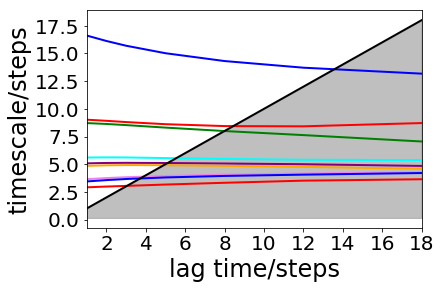

In [20]:
# Plot implied time scales
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
#plt.xlim(0,900)
#plt.ylim(-100,1700)
#plt.xlim(0,100)
#plt.ylim(100,10000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [21]:
msm_MSMRD = pyemma.msm.estimate_markov_model(milestoning.dTraj, lag=1, reversible=False)

In [22]:
MTT_msm = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        MTT_msm[i,j] = msm_MSMRD.mfpt(i,j)*0.1

In [23]:
import pickle
BDtransitionTimesMSM = pickle.load(open('MTTs_convergence.p'))

[ 0.35138207  0.35673513  0.37266685  0.35221654  0.3843218   0.35226517
  0.35091328  0.36077208  0.36695652  0.        ]


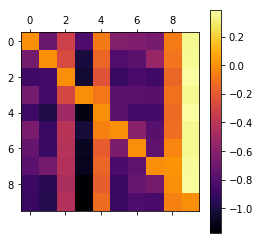

In [27]:
diff = np.zeros_like(MTT_msm)
for i in range(len(diff)):
    for j in range(len(diff)):
        if i != j:
            diff[i,j] = (MTT_msm[i,j] - BDtransitionTimesMSM[48][i,j])#/BDtransitionTimesMSM[48][i,j]
plt.matshow(diff, cmap=plt.get_cmap('inferno'))
#plt.clim((-0.2,0.3))
plt.colorbar()
np.amax(abs(diff))
#plt.savefig('2DasymError.pdf')
print diff[:,9]

In [31]:
BDtransitionTimesMSM[-1][2,9]

2.0997769072900434

In [28]:
stat_distr_reference = np.array([ 0.02885661,  0.03404936,  0.04002925,  0.03715941,  0.03915249,  0.03511926, 0.03510042,  0.03580847,  0.03664384,  0.67808089])

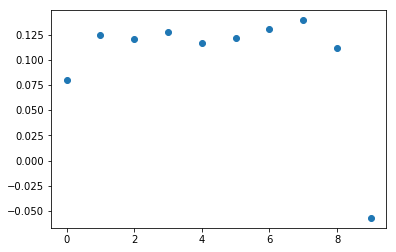

In [30]:
plt.plot((msm_MSMRD.stationary_distribution - stat_distr_reference)/stat_distr_reference, 'o')

In [32]:
inFlux4 = np.where(np.logical_and(sim.traj[:-1, 3] != -1, sim.traj[1:, 3] == -1))[0]

In [33]:
exits = np.where(np.logical_and(sim.traj[:-1,3] >= 0, sim.traj[1:,3]==-1))[0]
entries = np.where(np.logical_and(sim.traj[:-1,3] == -1, sim.traj[1:,3]>=0))[0]
innerEntries = np.where(np.logical_and(sim.traj[:-1,3] == -1, np.logical_and(sim.traj[1:,3]>=0, sim.traj[1:,3] < 9)))[0]

0.077293608007


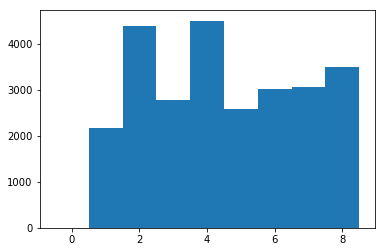

In [34]:
entriesHist = discreteHistogram(sim.traj[innerEntries+1, 3])
print len(innerEntries)/float(len(entries))

In [35]:
print sim.traj[1]
print model.parameters['NangularPartitions']

[  0.1   0.    0.   83. ]
12


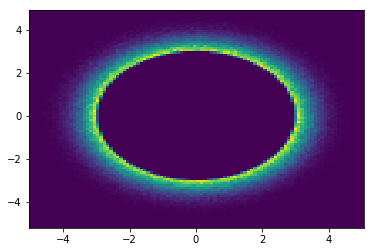

In [36]:
hist = plt.hist2d(sim.traj[exits+1, 1], sim.traj[exits+1, 2], bins = 100)

(array([ 6698.,  6652.,  6679.,  6578.,  6846.,  6668.,  6745.,  6749.,
         6725.,  6652.,  6785.,  6742.,  6676.,  6565.,  6655.,  6707.,
         6708.,  6670.,  6592.,  6599.,  6819.,  6842.,  6533.,  6838.,
         6641.,  6690.,  6596.,  6760.,  6717.,  6725.,  6620.,  6811.,
         6702.,  6715.,  6445.,  6779.,  6606.,  6905.,  6865.,  6750.,
         6942.,  6906.,  6856.,  6814.,  6787.,  6877.,  6706.,  6791.,
         6617.,  6763.]),
 array([ -1.79999801e+02,  -1.72799807e+02,  -1.65599813e+02,
         -1.58399818e+02,  -1.51199824e+02,  -1.43999830e+02,
         -1.36799836e+02,  -1.29599841e+02,  -1.22399847e+02,
         -1.15199853e+02,  -1.07999859e+02,  -1.00799864e+02,
         -9.35998700e+01,  -8.63998758e+01,  -7.91998815e+01,
         -7.19998872e+01,  -6.47998930e+01,  -5.75998987e+01,
         -5.03999044e+01,  -4.31999101e+01,  -3.59999159e+01,
         -2.87999216e+01,  -2.15999273e+01,  -1.43999331e+01,
         -7.19993878e+00,   5.54927997e-05,   

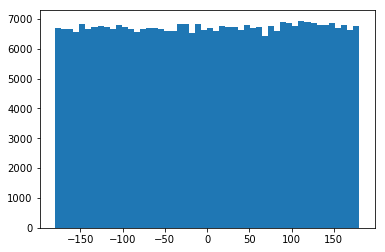

In [37]:
plt.hist(np.arctan2(sim.traj[exits+1, 1], sim.traj[exits+1, 2])*180./np.pi, bins=50)

128.0
141


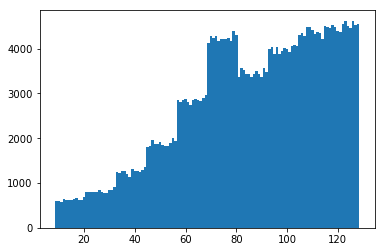

In [57]:
exitHist = discreteHistogram(sim.traj[exits, 3])
print np.amax(sim.traj[exits, 3])
print len(T)

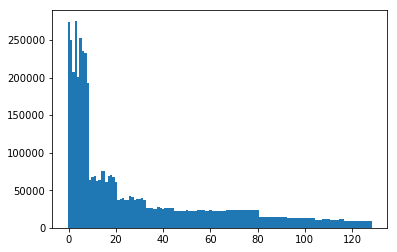

In [59]:
msmRegion = np.where(sim.traj[:,3] >-1)[0]
stat_distr = discreteHistogram(sim.traj[msmRegion,3])

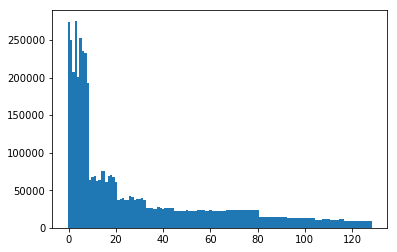

In [39]:
MSMregion = np.where(sim.traj[:,3]>=0)[0]
statDistr = discreteHistogram(sim.traj[MSMregion, 3])

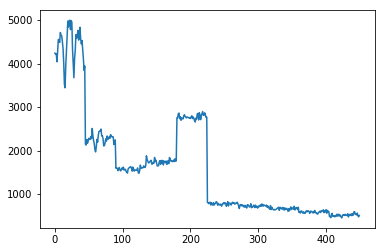

In [46]:
plt.plot(statDistr[0][0][9:])

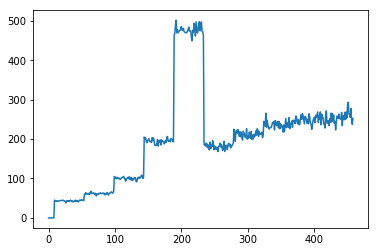

In [47]:
plt.plot(statDistr[0][0]*np.sum(T[:-45,-45:], axis=1))

AssertionError: Chosen set contains states that are not included in the active set.

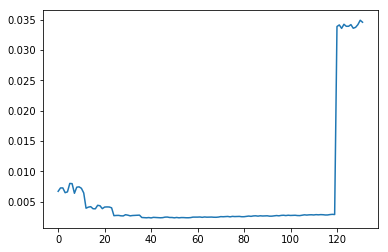

In [40]:
MSM = pyemma.msm.markov_model(T)
plt.plot(MSM.stationary_distribution[9:])
bathStates = [i for i in range(len(T)-m, 504)]
mfpt_fullMatrix = np.zeros((10,10))
for i in range(0, 9):
    mfpt_fullMatrix[i,9] = MSM.mfpt(i, bathStates) * 0.1
    mfpt_fullMatrix[9, i] = MSM.mfpt(bathStates, i) * 0.1
    for j in range(0,9):
        mfpt_fullMatrix[i,j] = MSM.mfpt(i,j) * 0.1

diff = np.zeros_like(MTT_msm)
for i in range(len(diff)):
    for j in range(len(diff)):
        if i != j:
            diff[i,j] = (MTT_msm[i,j] - mfpt_fullMatrix[i,j])/mfpt_fullMatrix[i,j]
plt.matshow(diff[:10,:10], cmap=plt.get_cmap('inferno'))
plt.colorbar()

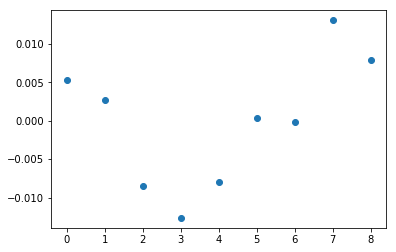

In [47]:
statDistrMSM = MSM.stationary_distribution[:9]/np.sum(MSM.stationary_distribution[:9]) 
statDistrHybrid = statDistr[0][0][:9]/np.sum(statDistr[0][0][:9])
plt.plot((statDistrMSM-statDistrHybrid)/statDistrMSM, 'o')

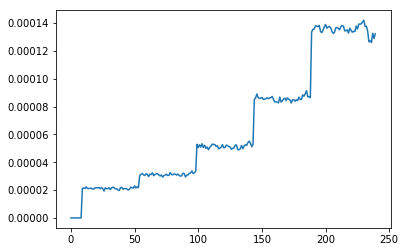

In [134]:
exitsMSM = plt.plot(MSM.stationary_distribution[:240]*np.sum(T[:240, -45:], axis=1))

In [48]:
referenceExitDistr = pickle.load(open('2DasymExitDistribution.p'))

In [61]:
MSMradius = 4.0
X = np.arange(3.0, 4.0, 0.01)
Zfull = np.zeros(X.shape[0]-1)
rad = np.linalg.norm(sim.traj[:,1:3], axis=1)
allExits = np.where(np.logical_and(rad[:-1]<3.0, rad[1:]>3.0))[0]
hist = np.histogram(rad[allExits+1], bins = X, normed=False)
Zfull += hist[0]
centers = (X[:-1] + X[1:]) /2.
#cp = plt.plot(centers, Zfull)
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
#plt.colorbar()

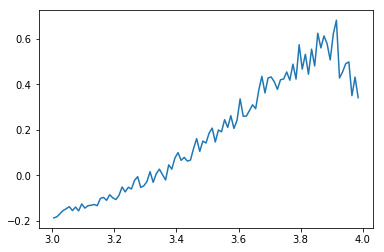

In [62]:
normalizedMSMRD = Zfull / np.sum(Zfull)
normalizedMD = referenceExitDistr / np.sum(referenceExitDistr)
plt.plot(centers, (normalizedMSMRD-normalizedMD)/normalizedMD)

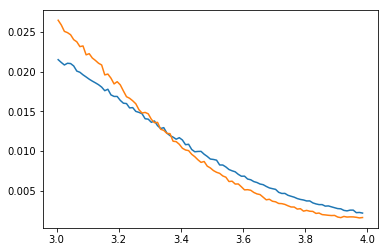

In [63]:
plt.plot(centers, normalizedMSMRD)
plt.plot(centers, normalizedMD)

In [77]:
print sim.traj[2]

[ 0.02       -1.74909968 -2.13589939 -1.        ]


In [54]:
print inFlux4.shape

(89892,)


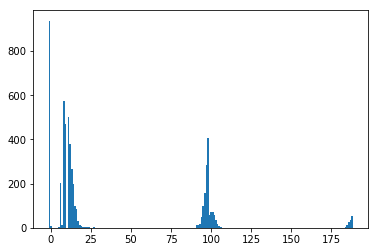

In [45]:
hist = discreteHistogram(sim.traj[inFlux4, 3])

In [51]:
selfFlux = np.where(np.logical_and(sim.traj[:-1, 3] == 4, sim.traj[1:, 3] == 4))[0]

In [52]:
print len(selfFlux)

31544


In [43]:
outFlux = np.where(np.logical_and(milestoning.dTraj[:-1] != 9, milestoning.dTraj[1:] == 9))[0]

In [44]:
print outFlux.shape

(16131,)


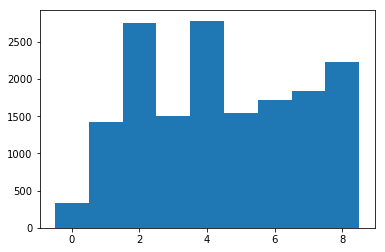

In [45]:
hist = discreteHistogram(milestoning.dTraj[outFlux])

/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


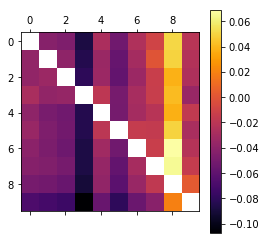

In [26]:
diff = (MTT_msm - BDtransitionTimesMSM[-1])/BDtransitionTimesMSM[-1]
plt.matshow(diff, cmap=plt.get_cmap('inferno'))
#plt.clim((-0.2,0.3))
plt.colorbar()
np.amax(diff)
plt.savefig('2DasymError.pdf')

/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


nan

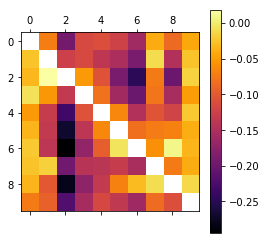

In [24]:
diff = (MTT - BDtransitionTimestraj)/BDtransitionTimestraj
plt.matshow(diff, cmap=plt.get_cmap('inferno'))
#plt.clim((-0.2,0.3))
plt.colorbar()
np.amax(diff)